# Stathub 2.0 - Premier League Prediction

3) GD Model Creation

In [212]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics

data = pd.read_csv("PremDataProcessed.csv")

To test our model, we will need two inputs: GD and Normalized Average Market Value. If the goal is to predict the 2023-24 season, we have the Normalized Average Market Value before the season starts but not the GD. Therefore, we will need to predict a particular team's GD before the seaason starts. Lets create this model by predicting GD given the year.

In this case, we dont care if "Year" and "GD" have a correlation. We just need to see if using year can create accurate predictions for GD.

In [245]:
gd_data = data.drop(columns=["Position", "Points", "Average_Market_Value", "Normalized_Average_Market_Value"])

#2004/05 season to the 2021/22 season
gd_data_wo_2022 = gd_data.head(len(gd_data) - 20)
gd_data_wo_2022

,Team,Goal_Difference,Year
0,chelsea fc,57,2004
1,manchester united,32,2004
2,arsenal fc,51,2004
3,liverpool fc,11,2004
4,tottenham hotspur,6,2004
...,...,...,...
355,brentford fc,-8,2021
356,crystal palace,4,2021
357,norwich city,-61,2021
358,watford fc,-43,2021


In [246]:
gd_data_2223 = gd_data.tail(20)
gd_data_2223

,Team,Goal_Difference,Year
360,manchester city,61,2022
361,arsenal fc,45,2022
362,chelsea fc,-9,2022
363,manchester united,15,2022
364,liverpool fc,28,2022
365,tottenham hotspur,7,2022
366,newcastle united,35,2022
367,brighton & hove albion,19,2022
368,aston villa,5,2022
369,wolverhampton wanderers,-27,2022


In [247]:
teams2223 = gd_data[gd_data["Year"] == 2022]["Team"].unique().tolist()
teams2223

['manchester city',
 'arsenal fc',
 'chelsea fc',
 'manchester united',
 'liverpool fc',
 'tottenham hotspur',
 'newcastle united',
 'brighton & hove albion',
 'aston villa',
 'wolverhampton wanderers',
 'leicester city',
 'west ham united',
 'southampton fc',
 'everton fc',
 'nottingham forest',
 'brentford fc',
 'leeds united',
 'crystal palace',
 'fulham fc',
 'afc bournemouth']

In [249]:
gd_year_predictions = []

def gd_year_prediction_model(num_degrees, std_dev, plots):
    
    gd_year_predictions.clear()
    teams2223 = gd_data[gd_data["Year"] == 2022]["Team"].unique().tolist()
    for i in range(20):
        team = teams2223[i]
        team_df = gd_data_wo_2022[gd_data_wo_2022['Team'] == team]

        degrees = 1
        if not team_df.empty: 
            team_std_dev = team_df['Goal_Difference'].std()

            if(team_std_dev > std_dev):
                degrees = num_degrees

            x = team_df['Year']
            y = team_df['Goal_Difference']

            x = x.values.reshape(-1,1)
            y = y.values.reshape(-1,1)

            poly = PolynomialFeatures(degree= degrees, include_bias=False)
            poly_features = poly.fit_transform(x)
            poly_reg_model = LinearRegression()
            poly_reg_model.fit(poly_features, y)

            y_predicted = poly_reg_model.predict(poly_features)

            predictions = poly_reg_model.predict(poly_features)

            poly22 = poly_features = poly.fit_transform([[2022]])
            gd_year_predictions.append(poly_reg_model.predict(poly22))
            gd_year_predictions[i] = gd_year_predictions[i][0][0].round()

            if(plots):
                plt.scatter(x, y, color = 'purple')
                plt.plot(x, y_predicted, color = 'green', linewidth = 3)
                plt.title(f"{team} - gd prediction \nStd Dev: {team_std_dev:.2f}, GD for 2022/23: {gd_year_predictions[i]}")
                plt.xlabel("Year")
                plt.ylabel("Goal Difference")
                plt.xticks(x.flatten(), rotation=90)  # Adjusting x-axis to show all labels
                plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
                plt.show()

        else:
            #No data for a team
            gd_year_predictions.append(-30)

In [217]:
#degree of 1
degrees = 1
std_dev = -1 #it doesnt matter because either way its 1 degree
gd_year_prediction_model(degrees, std_dev, plots=False)

#create df
teams_gd_year_df = pd.DataFrame({'Team': teams2223, 'Goal_Difference': gd_data_2223["Goal_Difference"], 'Predicted_Goal_Difference': gd_year_predictions})

#calculate difference
diff = 0
for team in range(20):
    diff += abs(teams_gd_year_df["Goal_Difference"].iloc[team]  -teams_gd_year_df["Predicted_Goal_Difference"].iloc[team]) 
diff /= 20

#------------------------------------------------------------------------------------------------------

#show results
print("degrees:", degrees,  "----> error: ", diff)
        
for degrees in range(2, 4):
    print("----------------------------------------------------")
    for std_dev in [4,6,8,10,11,12,14,16,18,]:
        #create predictions
        gd_year_prediction_model(degrees, std_dev, plots=False)

        #create df
        teams_gd_year_df = pd.DataFrame({'Team': teams2223, 'Goal_Difference': gd_data_2223["Goal_Difference"], 'Predicted_Goal_Difference': gd_year_predictions})

        #calculate difference
        diff = 0
        for team in range(20):
            diff += abs(teams_gd_year_df["Goal_Difference"].iloc[team]  -teams_gd_year_df["Predicted_Goal_Difference"].iloc[team]) 
        diff /= 20

        #show results
        print("degrees:", degrees, "| std_dev:", std_dev, "----> error: ", diff)

degrees: 1 ----> error:  23.4
----------------------------------------------------
degrees: 2 | std_dev: 4 ----> error:  23.5
degrees: 2 | std_dev: 6 ----> error:  21.75
degrees: 2 | std_dev: 8 ----> error:  21.75
degrees: 2 | std_dev: 10 ----> error:  22.25
degrees: 2 | std_dev: 11 ----> error:  22.05
degrees: 2 | std_dev: 12 ----> error:  22.05
degrees: 2 | std_dev: 14 ----> error:  22.4
degrees: 2 | std_dev: 16 ----> error:  22.6
degrees: 2 | std_dev: 18 ----> error:  22.75
----------------------------------------------------
degrees: 3 | std_dev: 4 ----> error:  22.25
degrees: 3 | std_dev: 6 ----> error:  20.95
degrees: 3 | std_dev: 8 ----> error:  20.95
degrees: 3 | std_dev: 10 ----> error:  19.7
degrees: 3 | std_dev: 11 ----> error:  19.1
degrees: 3 | std_dev: 12 ----> error:  19.1
degrees: 3 | std_dev: 14 ----> error:  19.3
degrees: 3 | std_dev: 16 ----> error:  20.2
degrees: 3 | std_dev: 18 ----> error:  24.25


This tells us that using year is best to predict goal difference when we create a regression model with a degree of **3** for teams with a standard deviation of over **12** in their GD data for the last 20 or so years with respect to minimizing average error. Tweaking these values will give us various degrees of error.

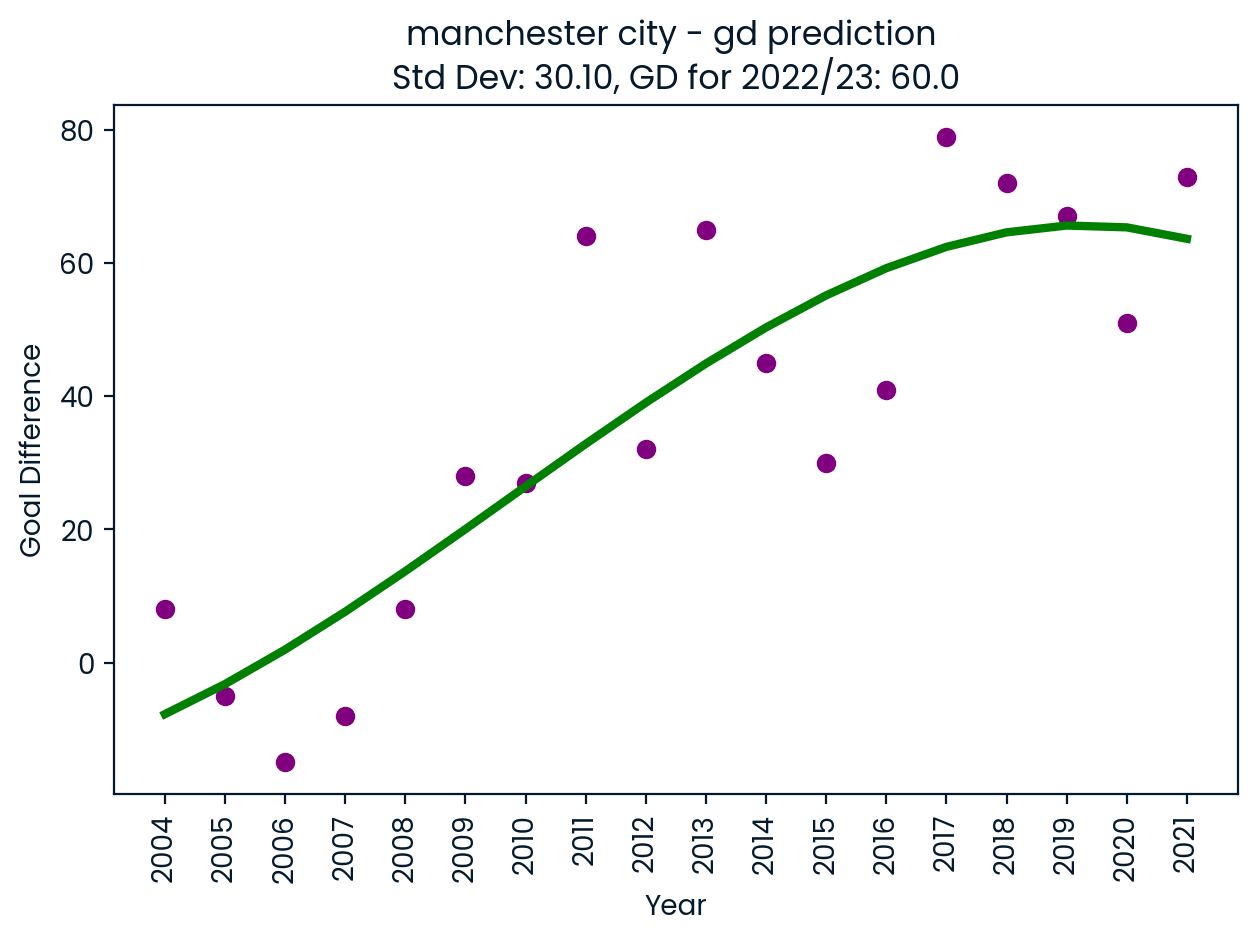

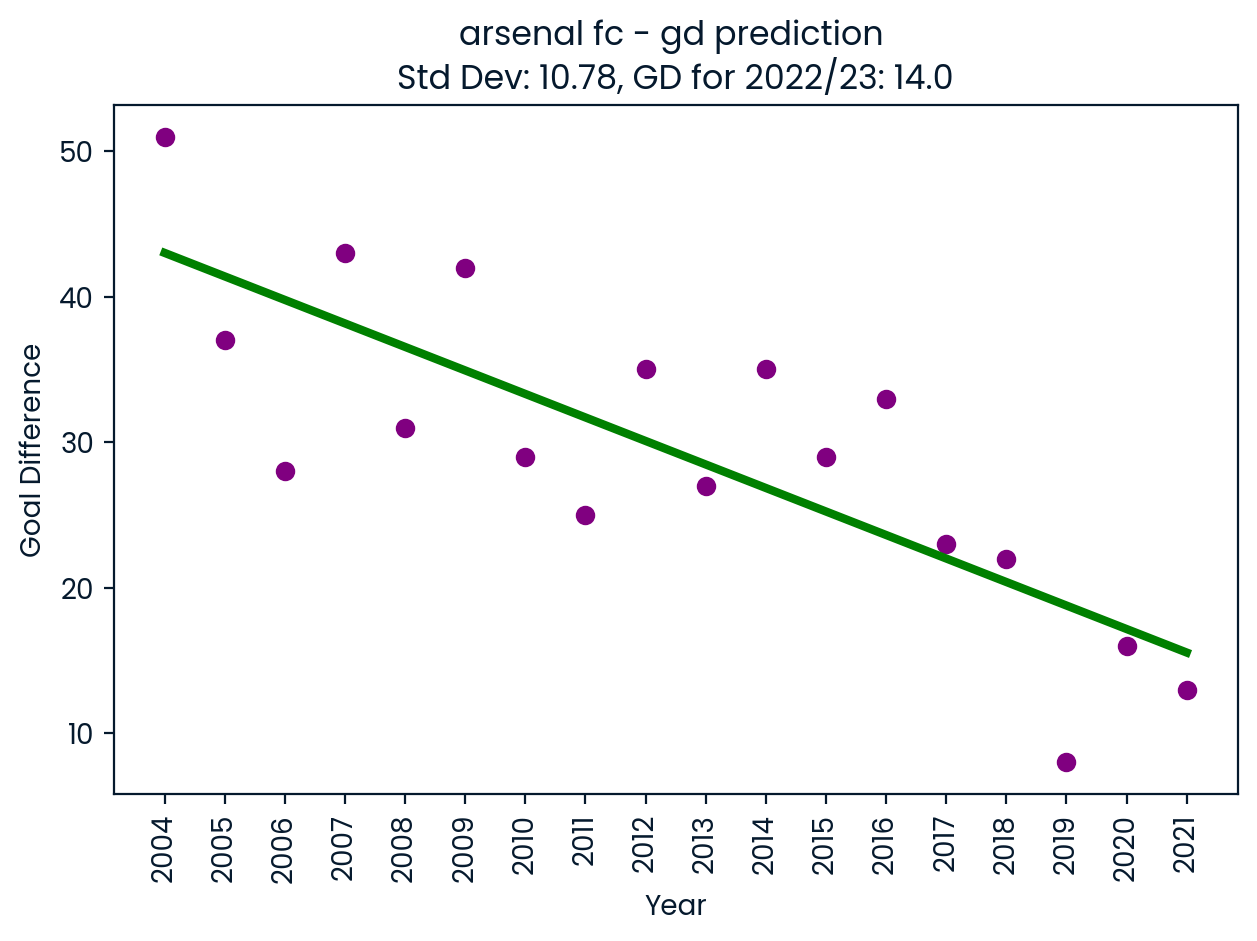

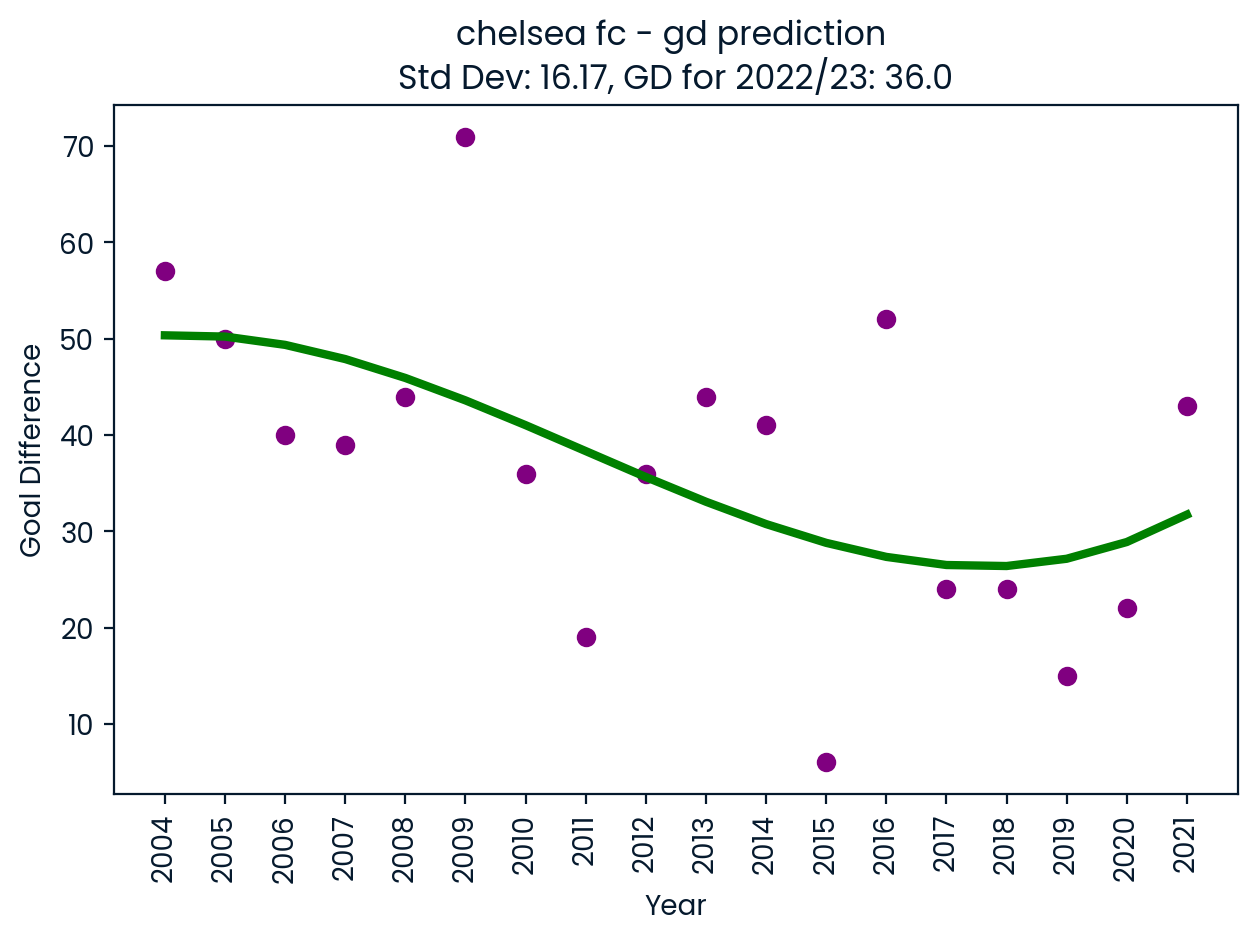

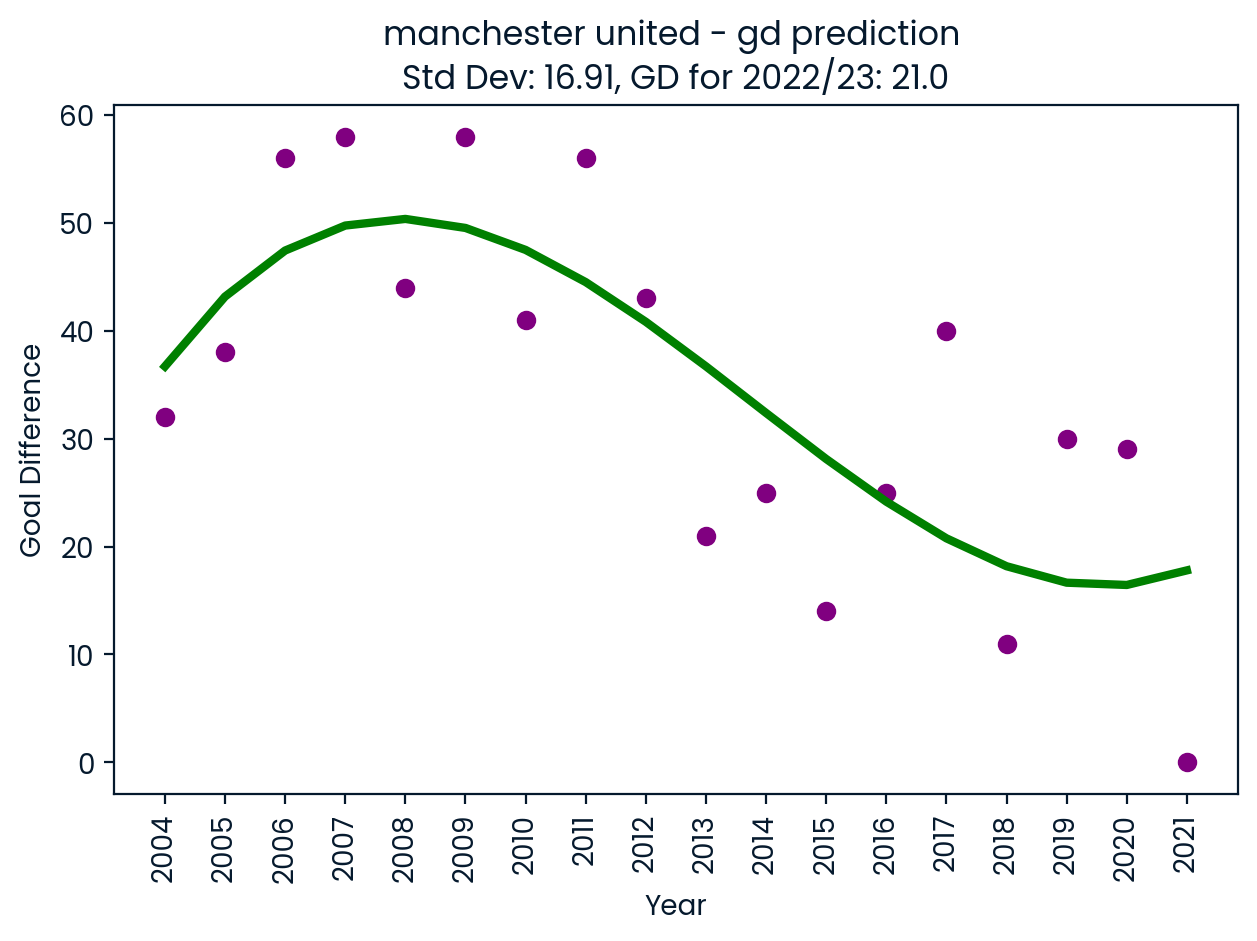

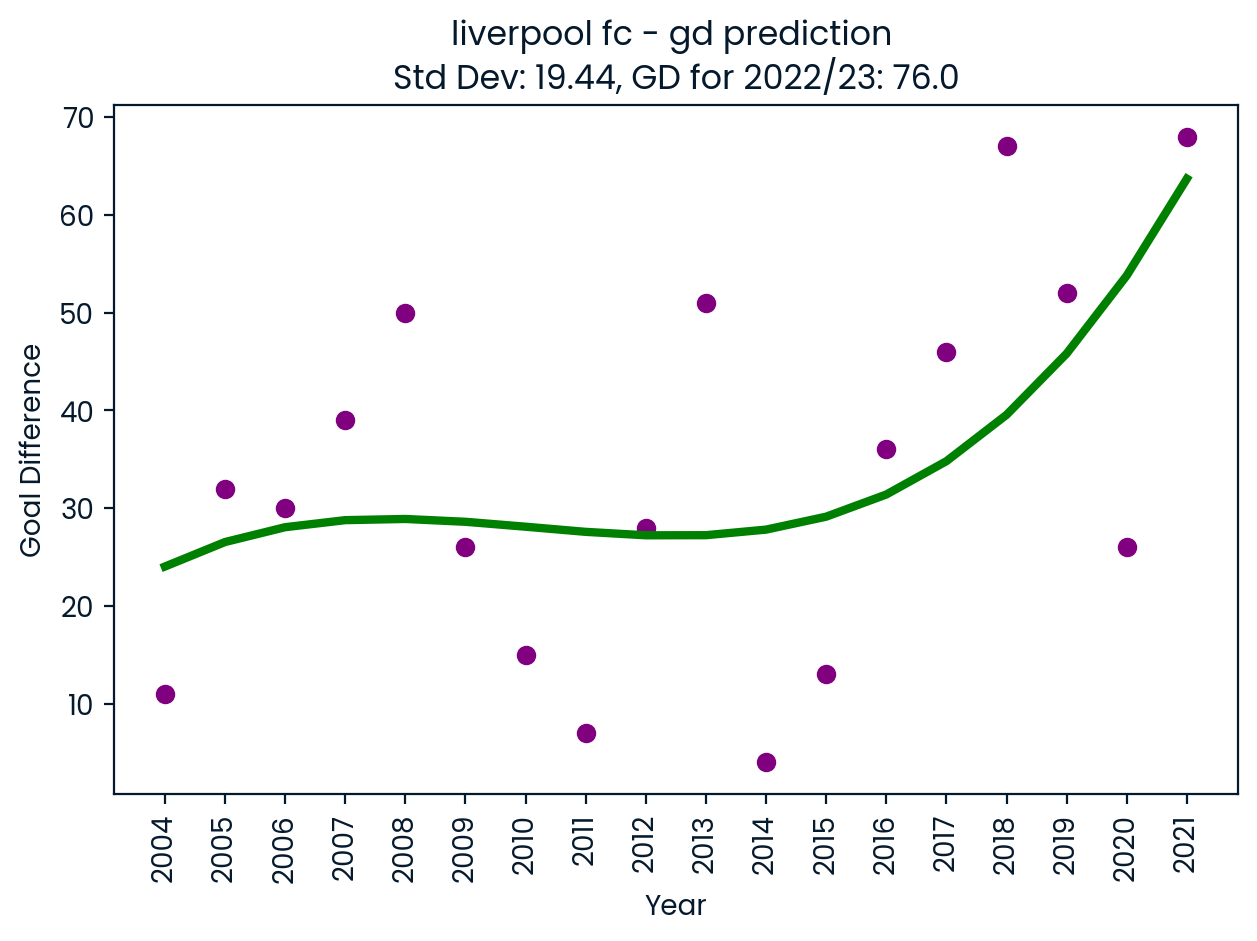

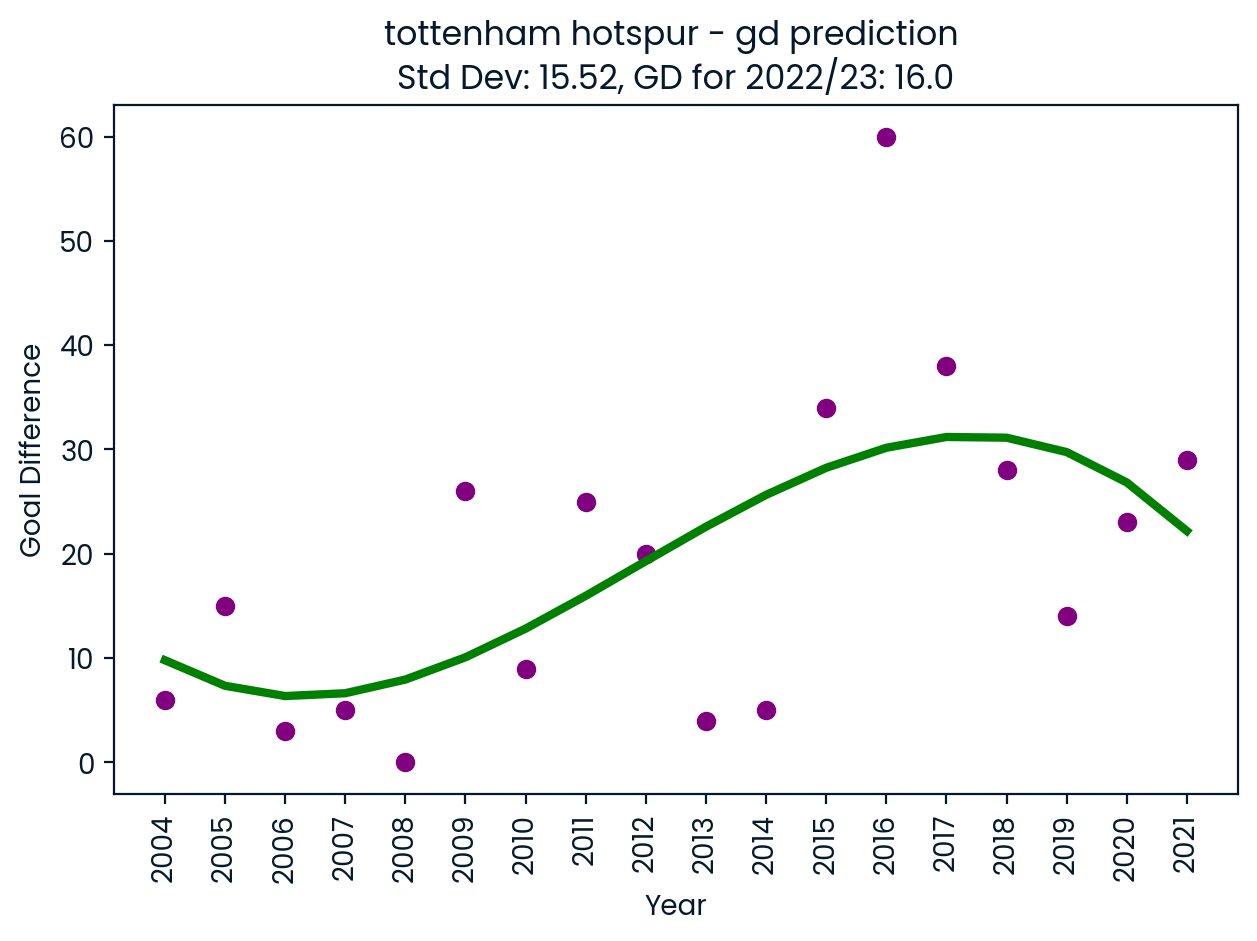

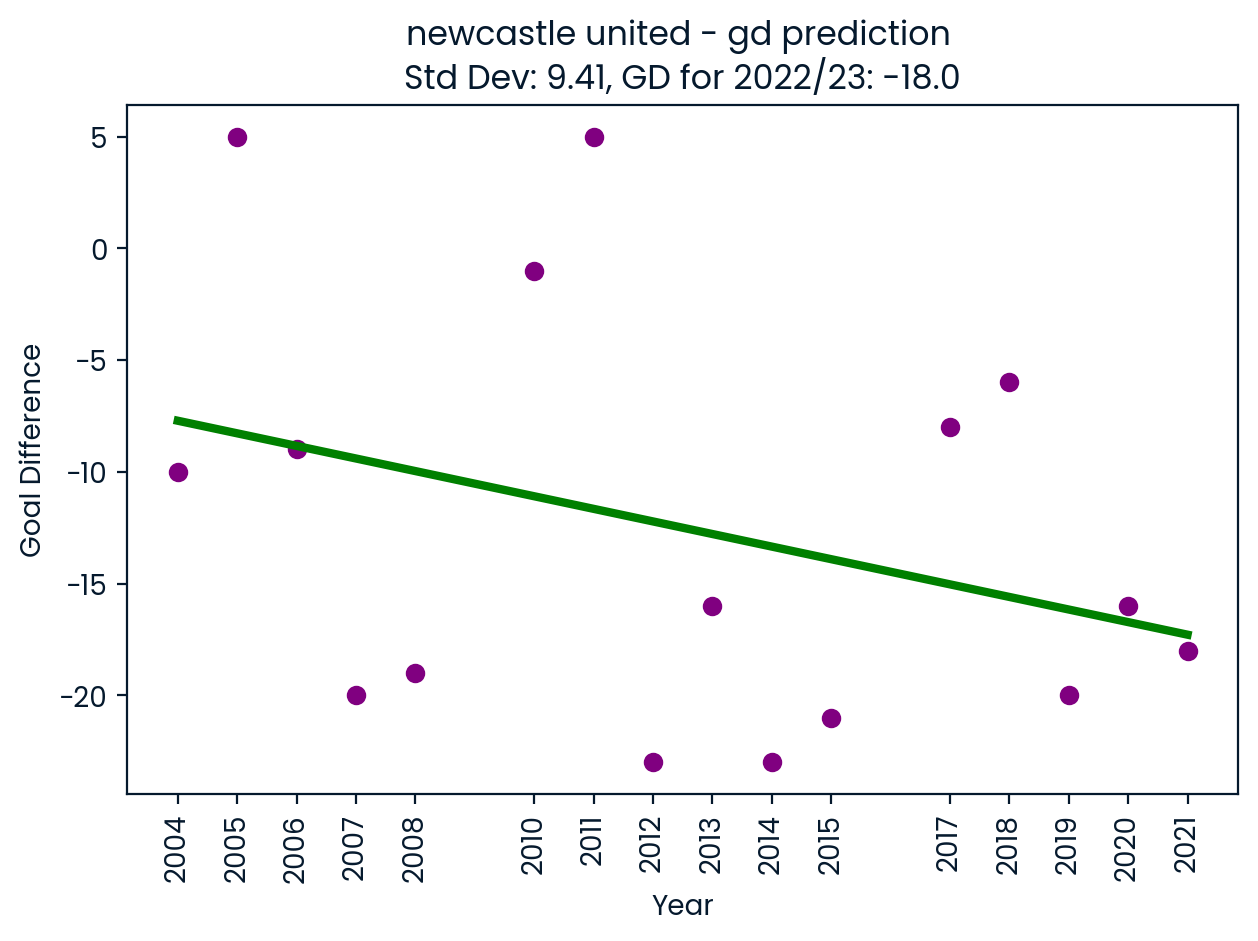

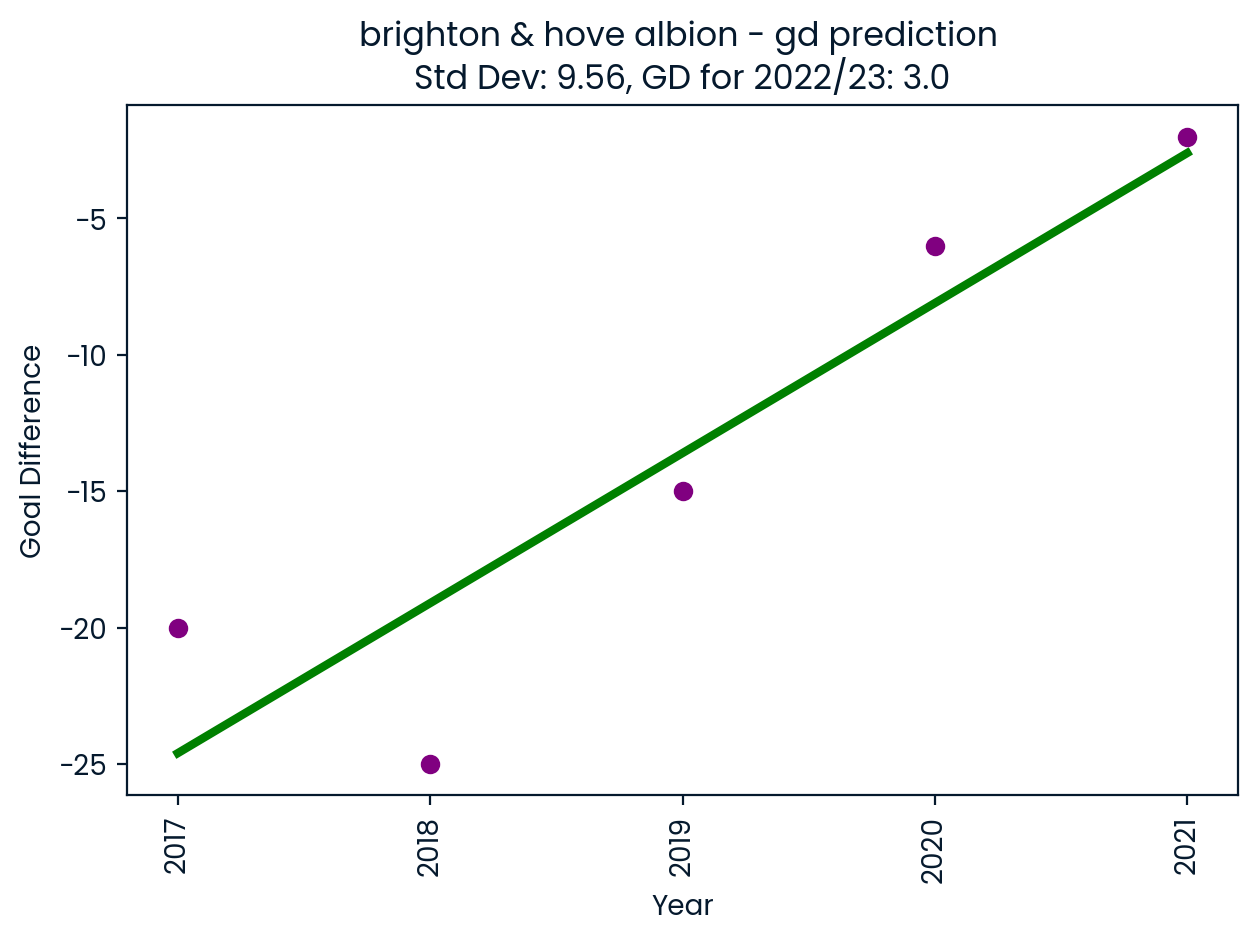

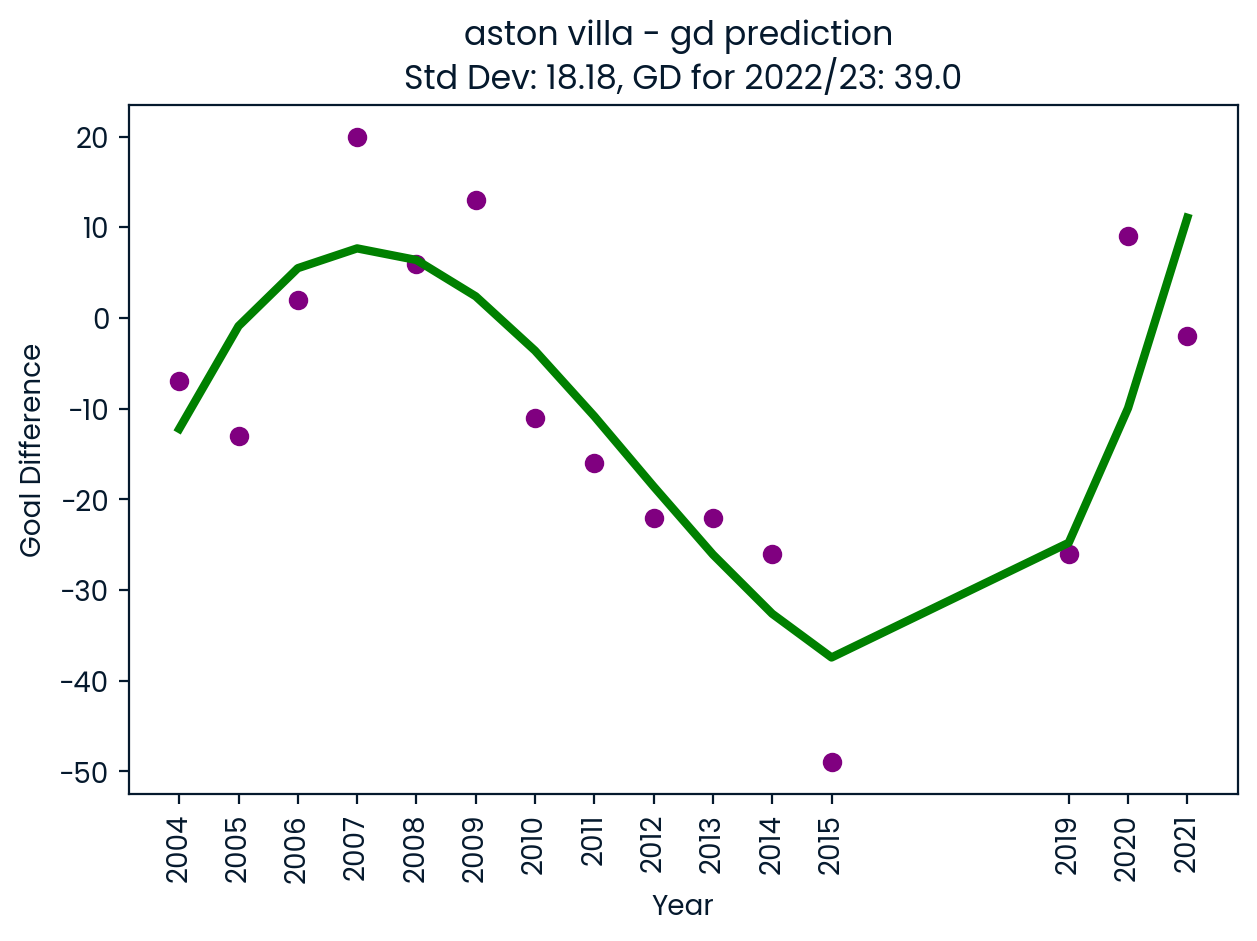

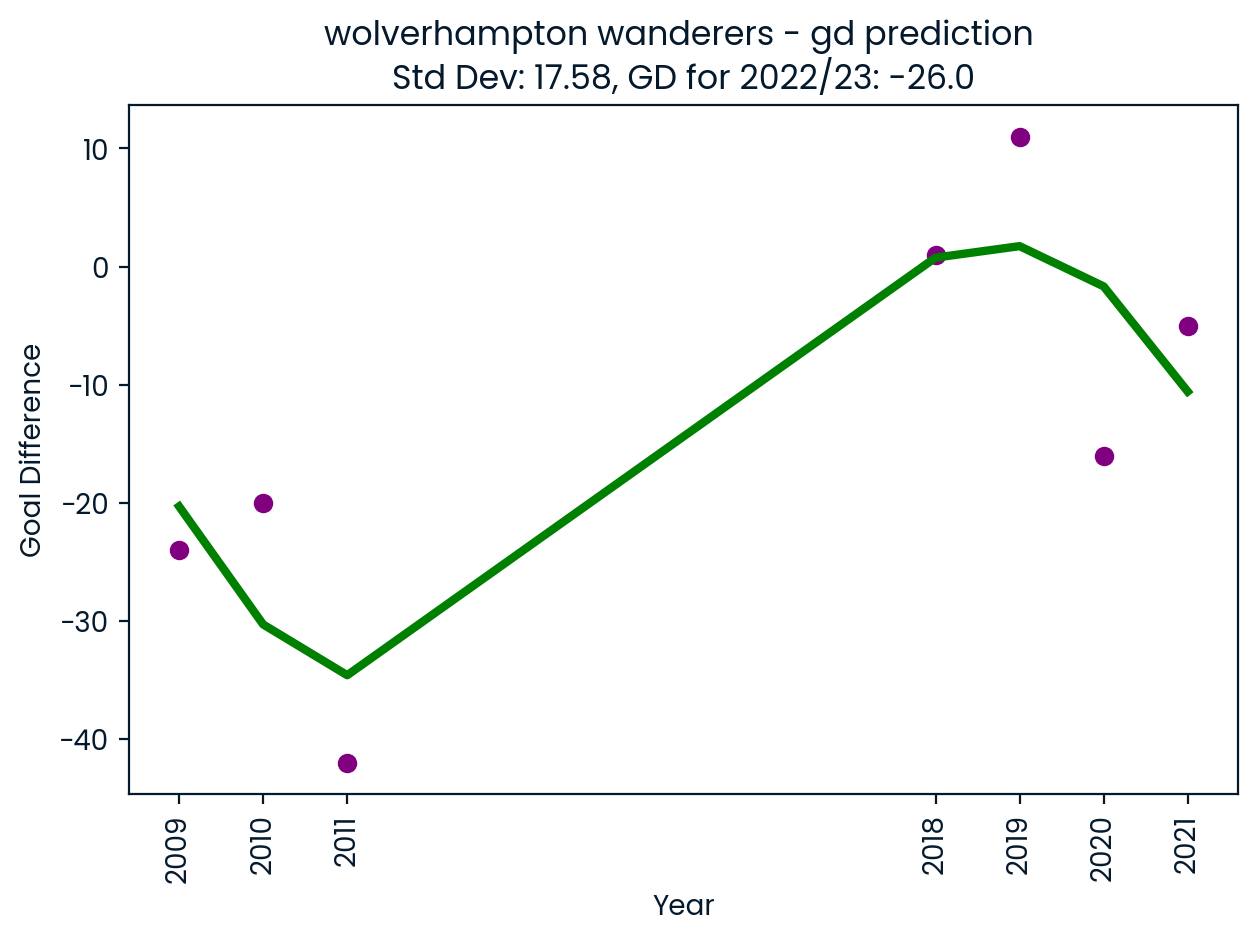

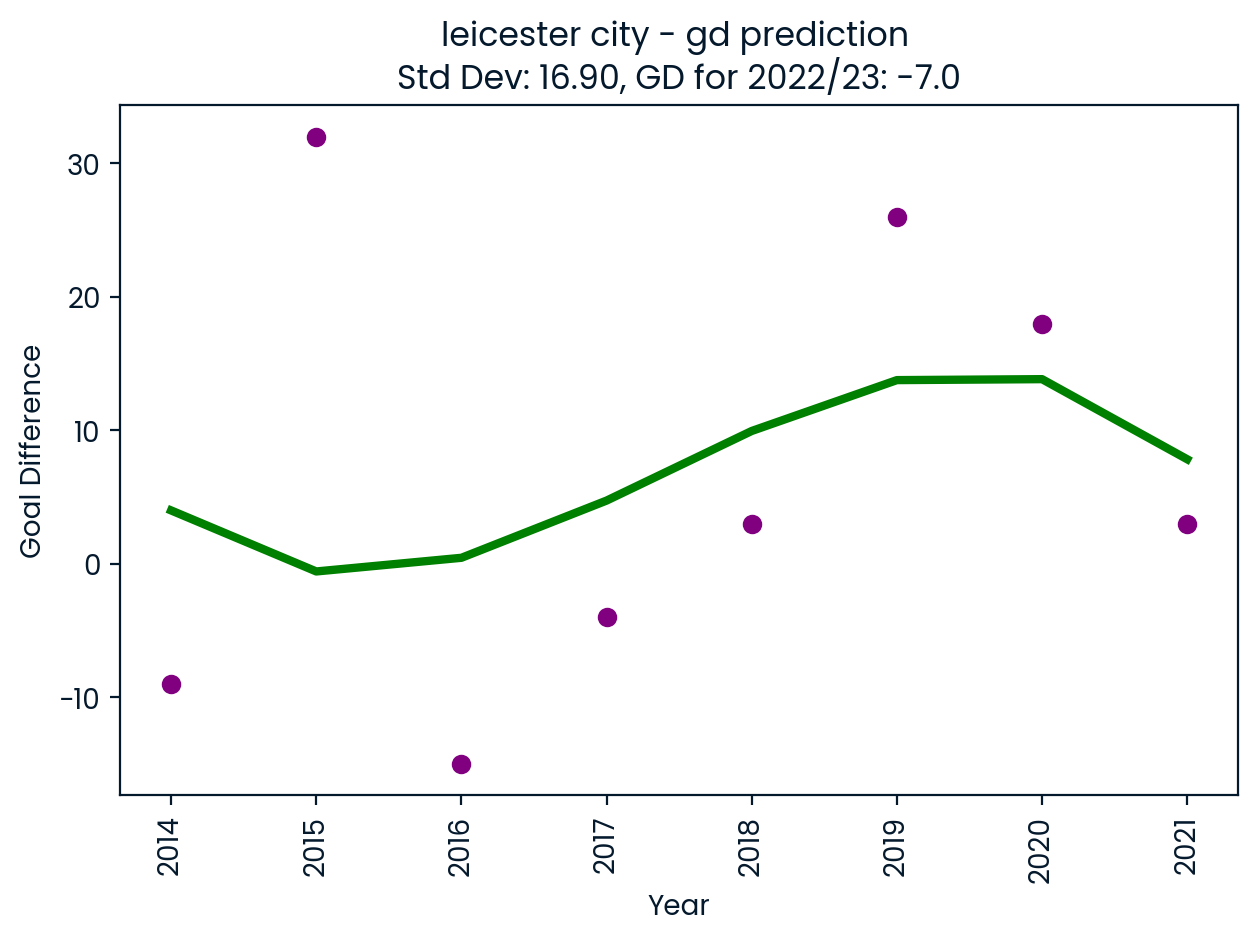

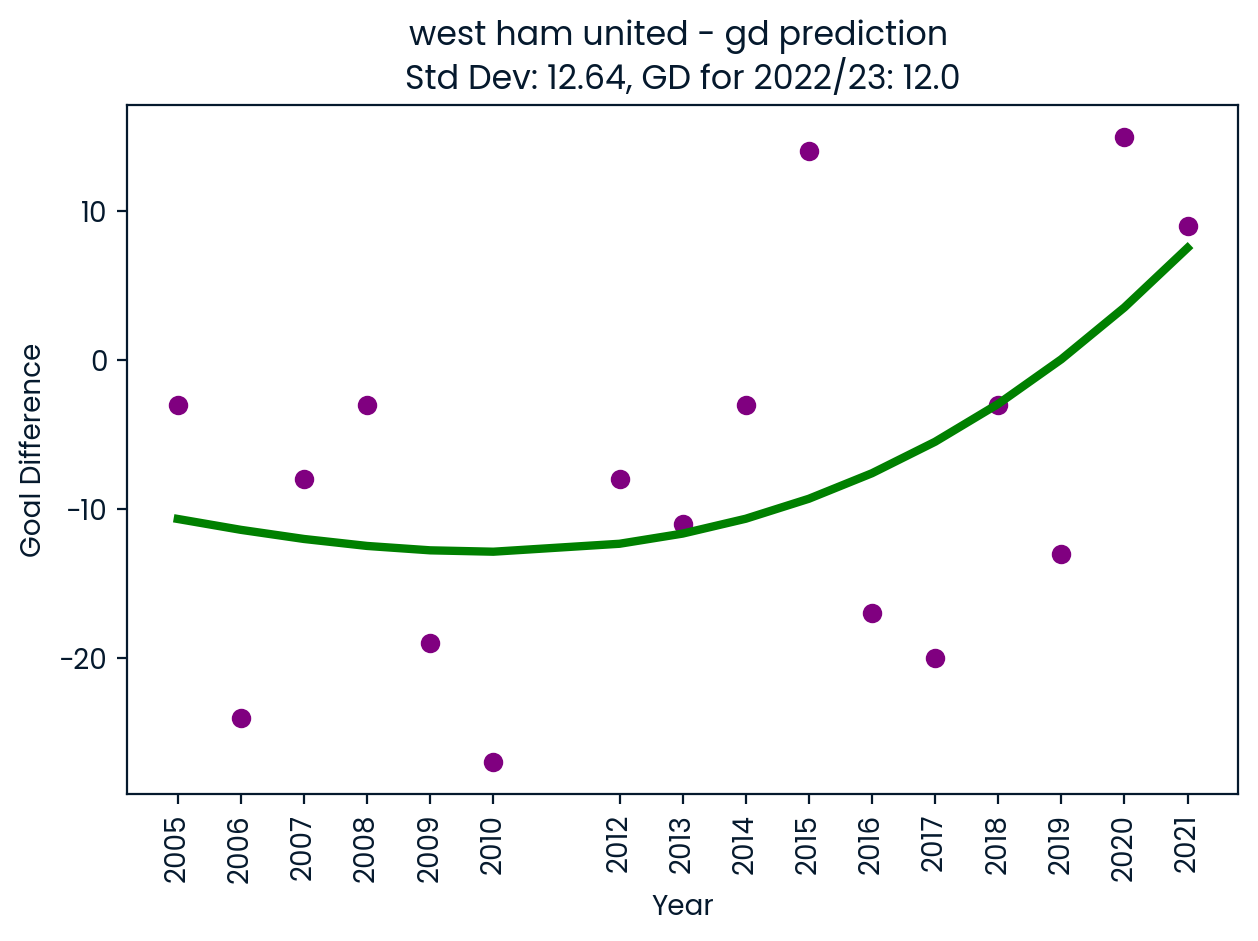

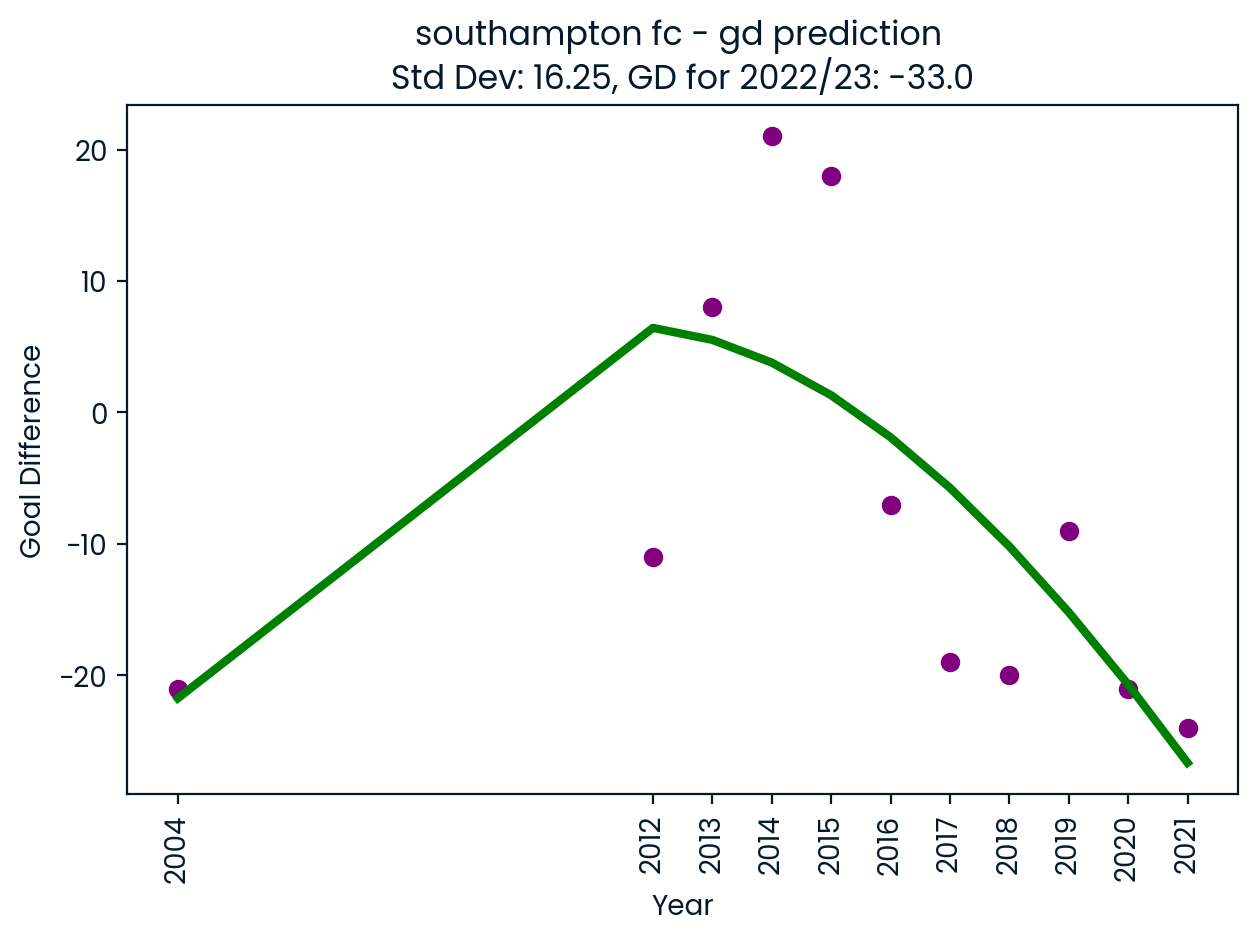

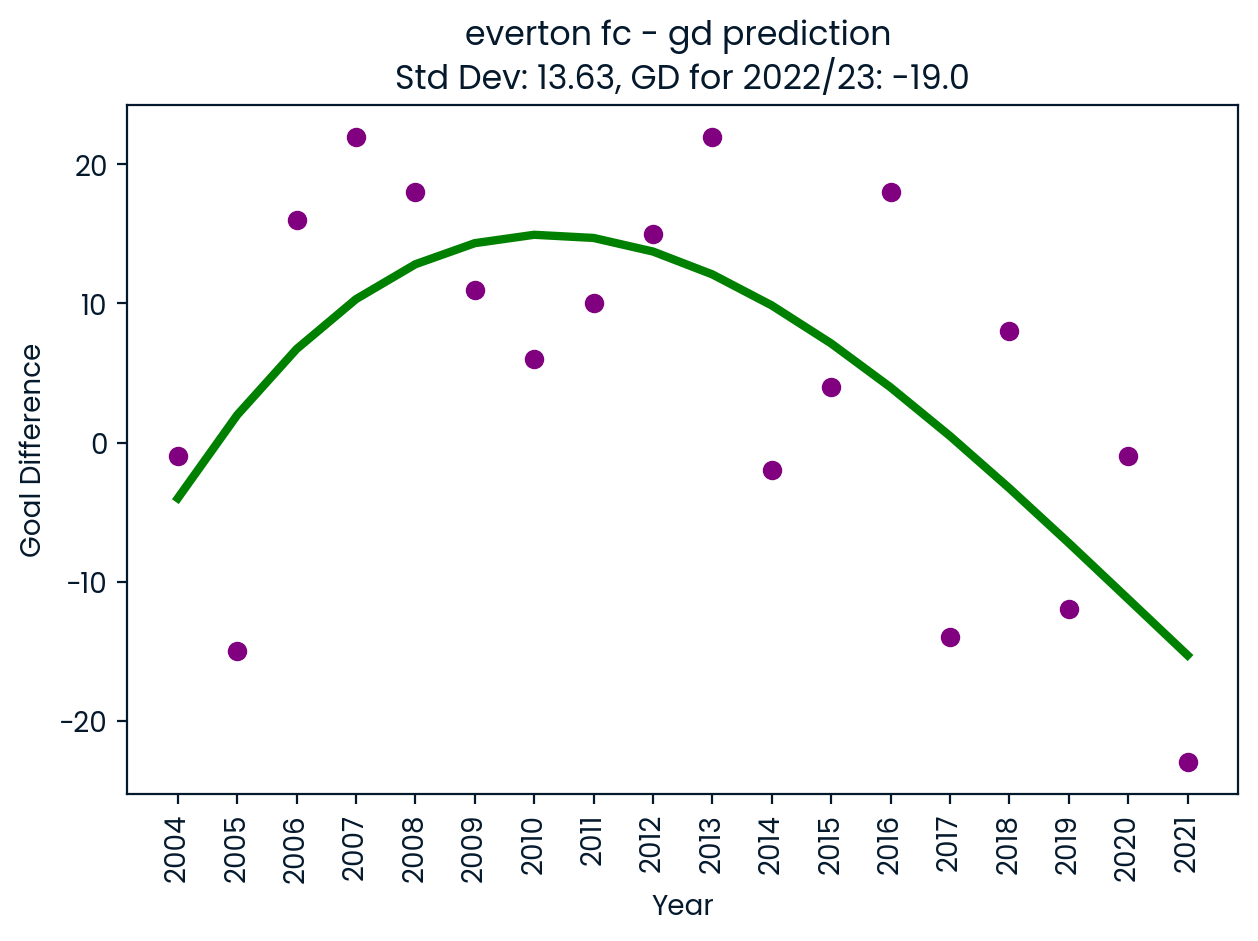

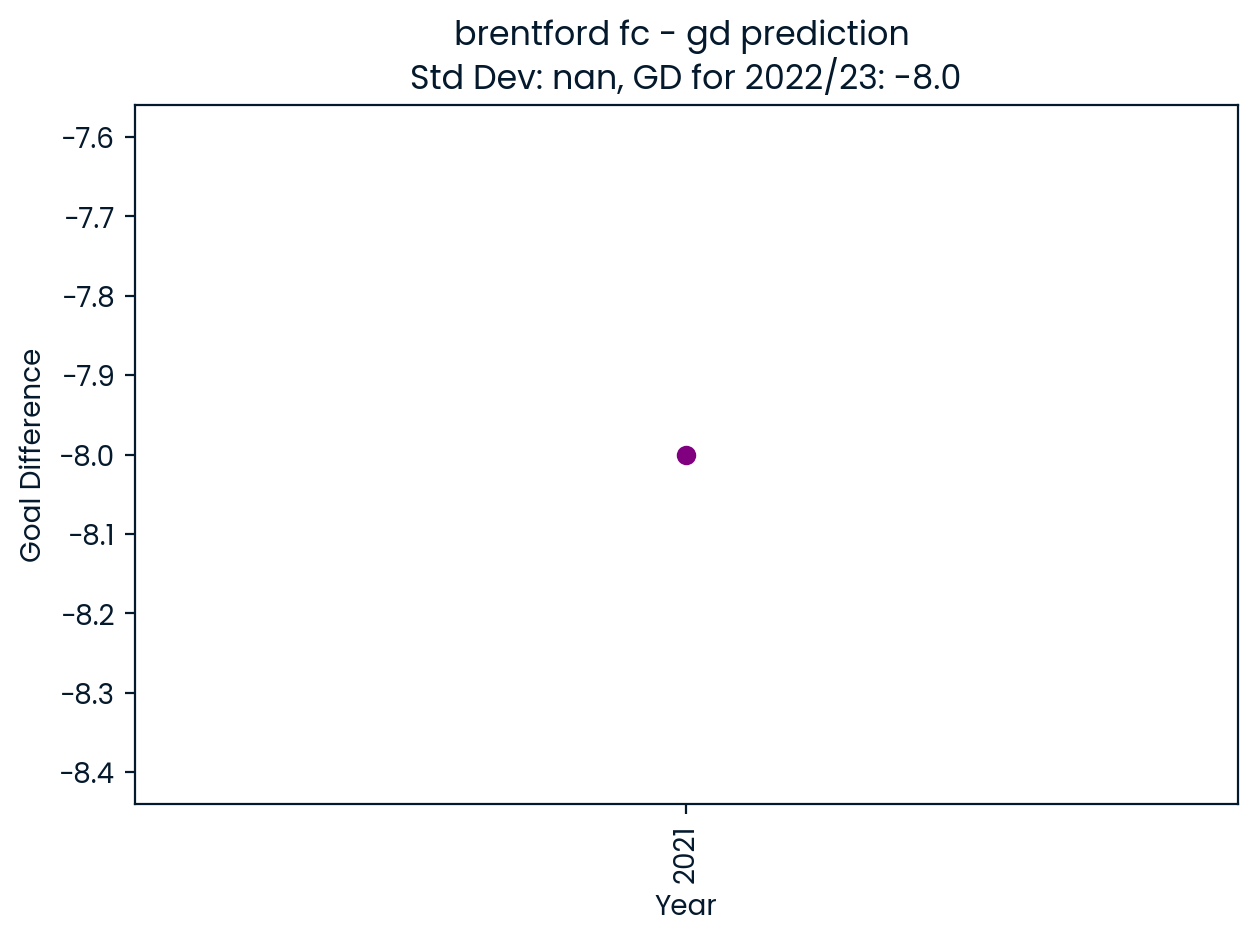

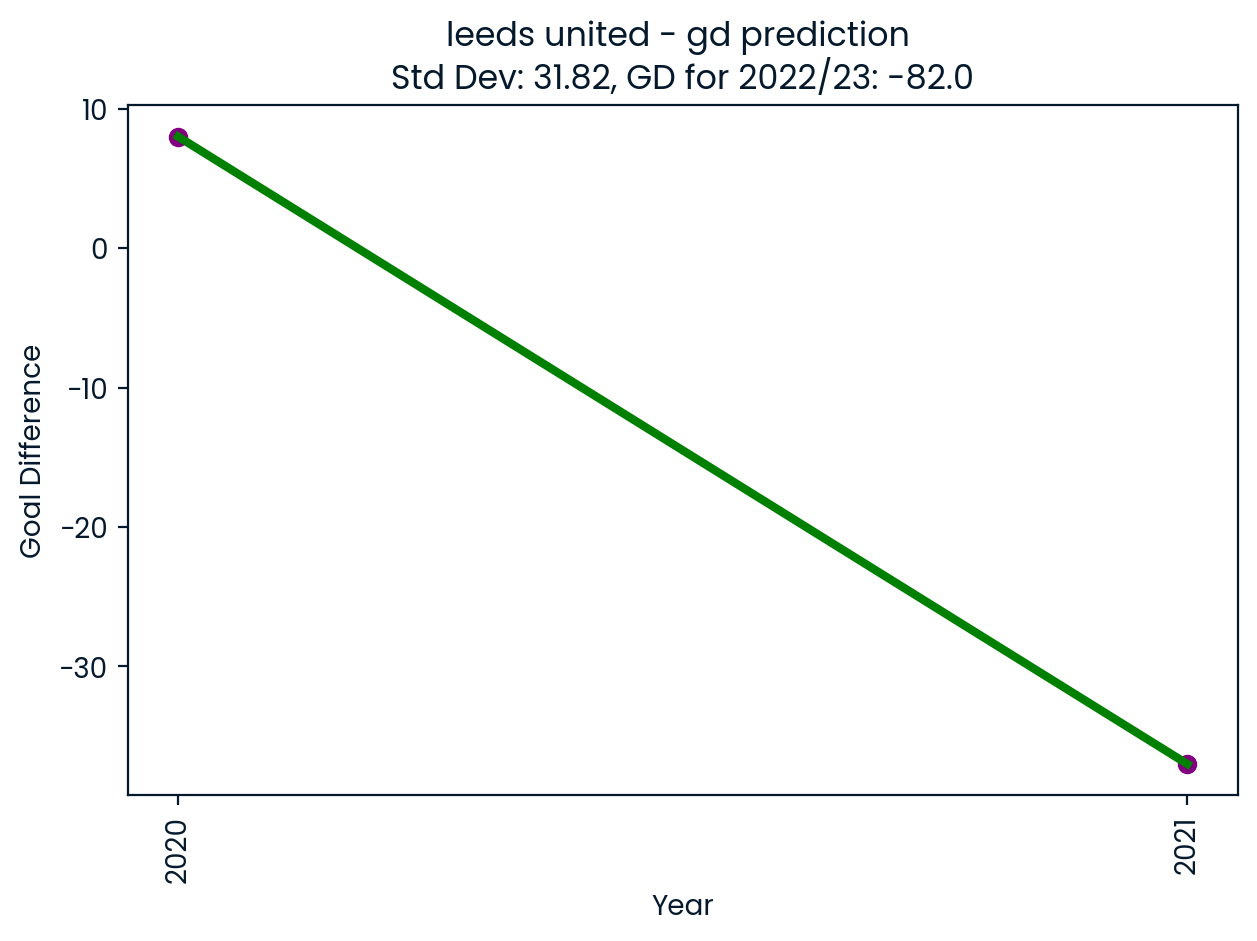

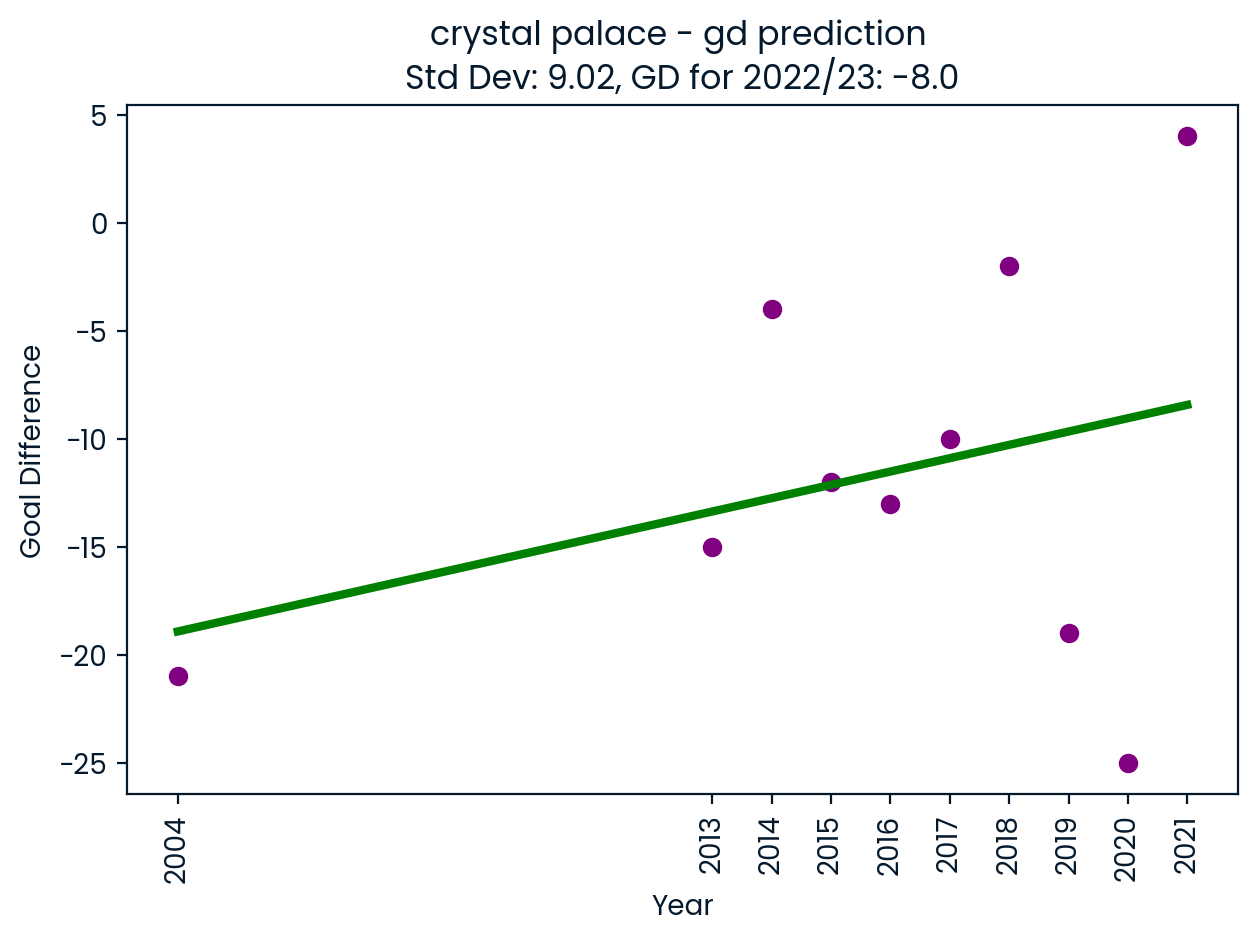

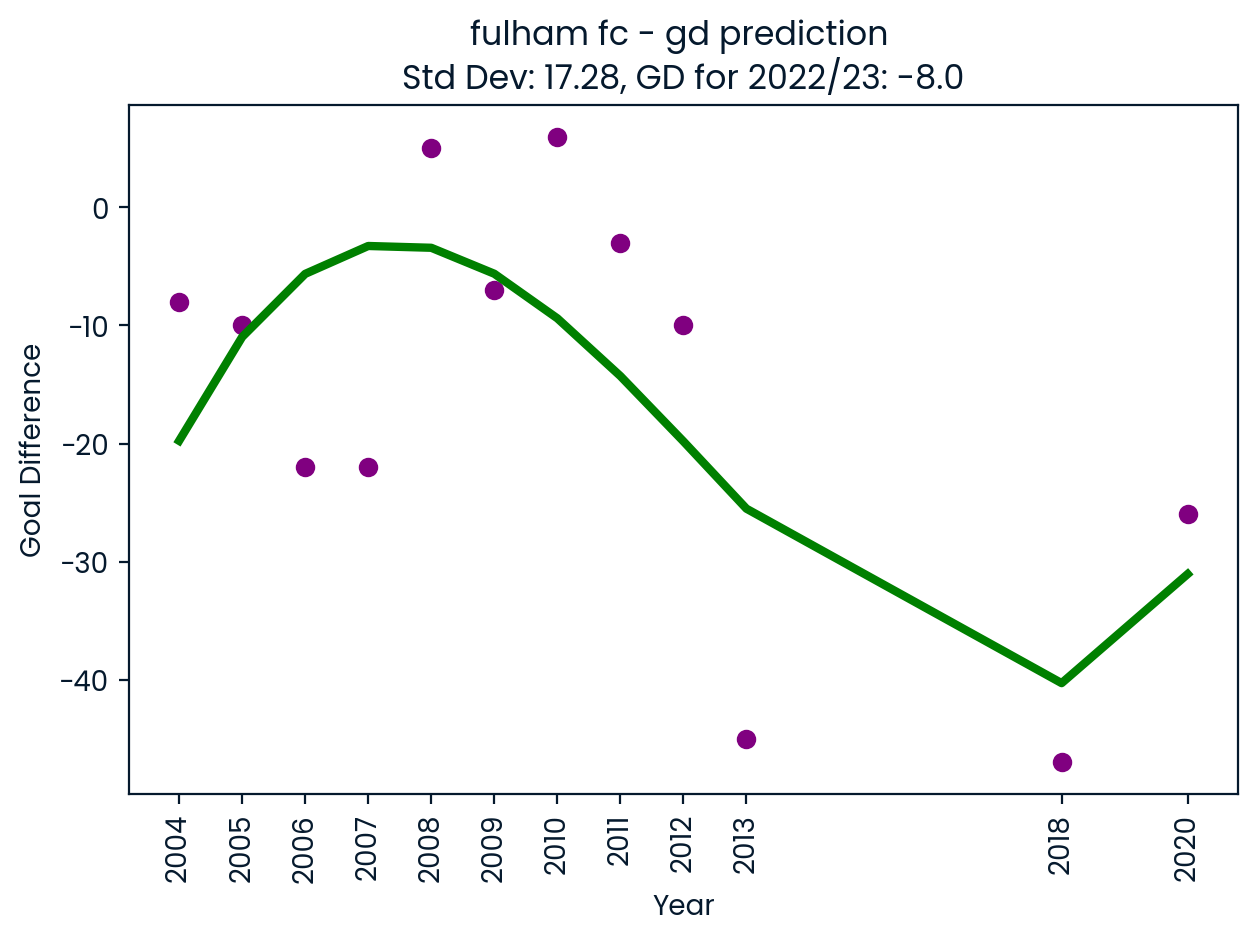

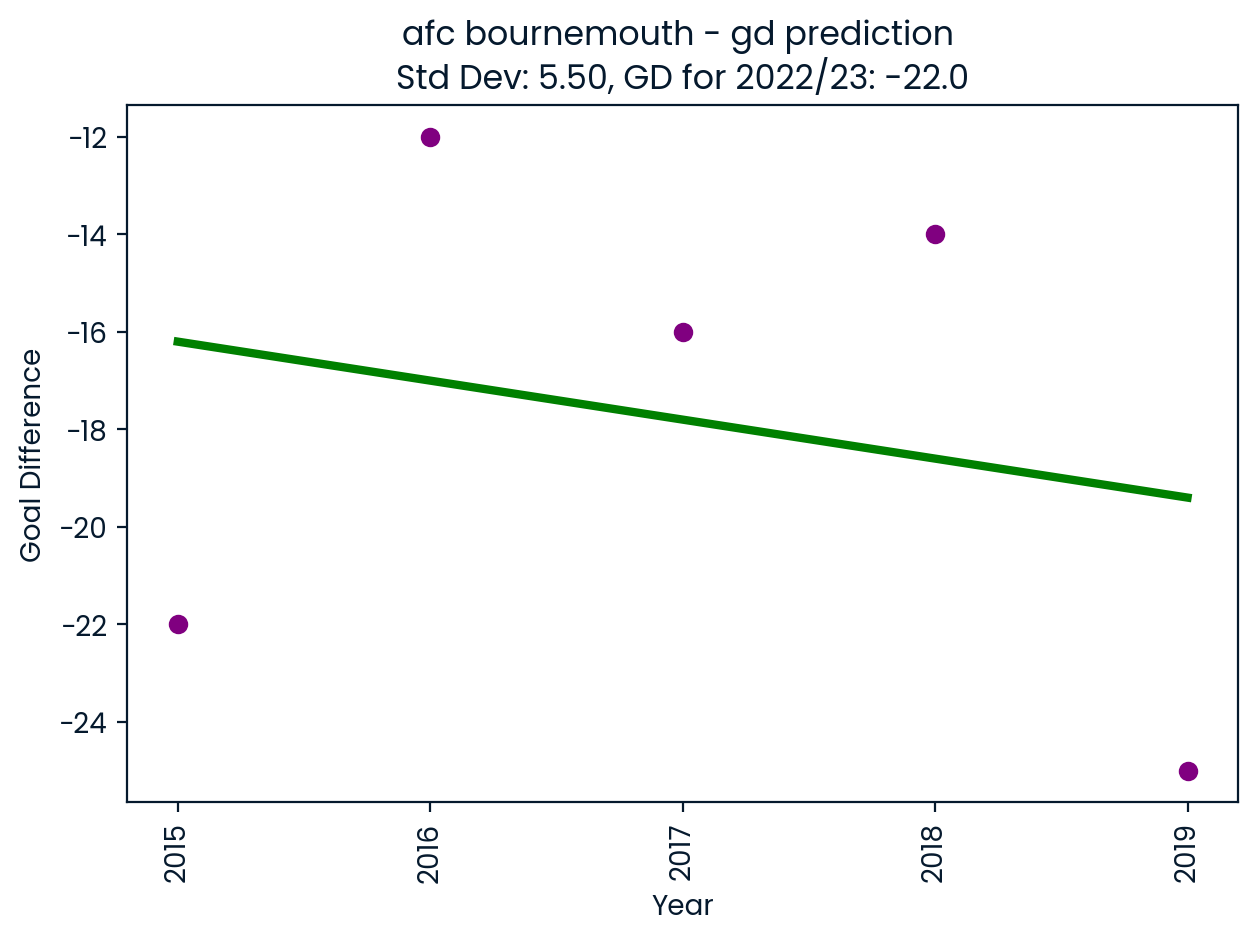

degrees: 3 | std_dev: 12 ----> error:  19.1


In [218]:
#create predictions
gd_year_prediction_model(3, 12, True)
differences = []

#create df
teams_gd_year_df = pd.DataFrame({'Team': teams2223, 'Goal_Difference': gd_data_2223["Goal_Difference"], 'Predicted_Goal_Difference': gd_year_predictions})

#calculate difference
diff = 0
for i in range(20):
    real_diff = (teams_gd_year_df["Goal_Difference"].iloc[i]  -teams_gd_year_df["Predicted_Goal_Difference"].iloc[i]) 
    differences.append(real_diff)
    diff += abs(real_diff)
diff /= 20
    

#show results
print("degrees:", 3, "| std_dev:", 12, "----> error: ", diff)

In [219]:
teams_gd_year_df = pd.DataFrame({'Team': teams2223, 'Goal_Difference': gd_data_2223["Goal_Difference"], 'Predicted_Goal_Difference': gd_year_predictions, 'Residual' : differences})

teams_gd_year_df

,Team,Goal_Difference,Predicted_Goal_Difference,Residual
360,manchester city,61,60.0,1.0
361,arsenal fc,45,14.0,31.0
362,chelsea fc,-9,36.0,-45.0
363,manchester united,15,21.0,-6.0
364,liverpool fc,28,76.0,-48.0
365,tottenham hotspur,7,16.0,-9.0
366,newcastle united,35,-18.0,53.0
367,brighton & hove albion,19,3.0,16.0
368,aston villa,5,39.0,-34.0
369,wolverhampton wanderers,-27,-26.0,-1.0


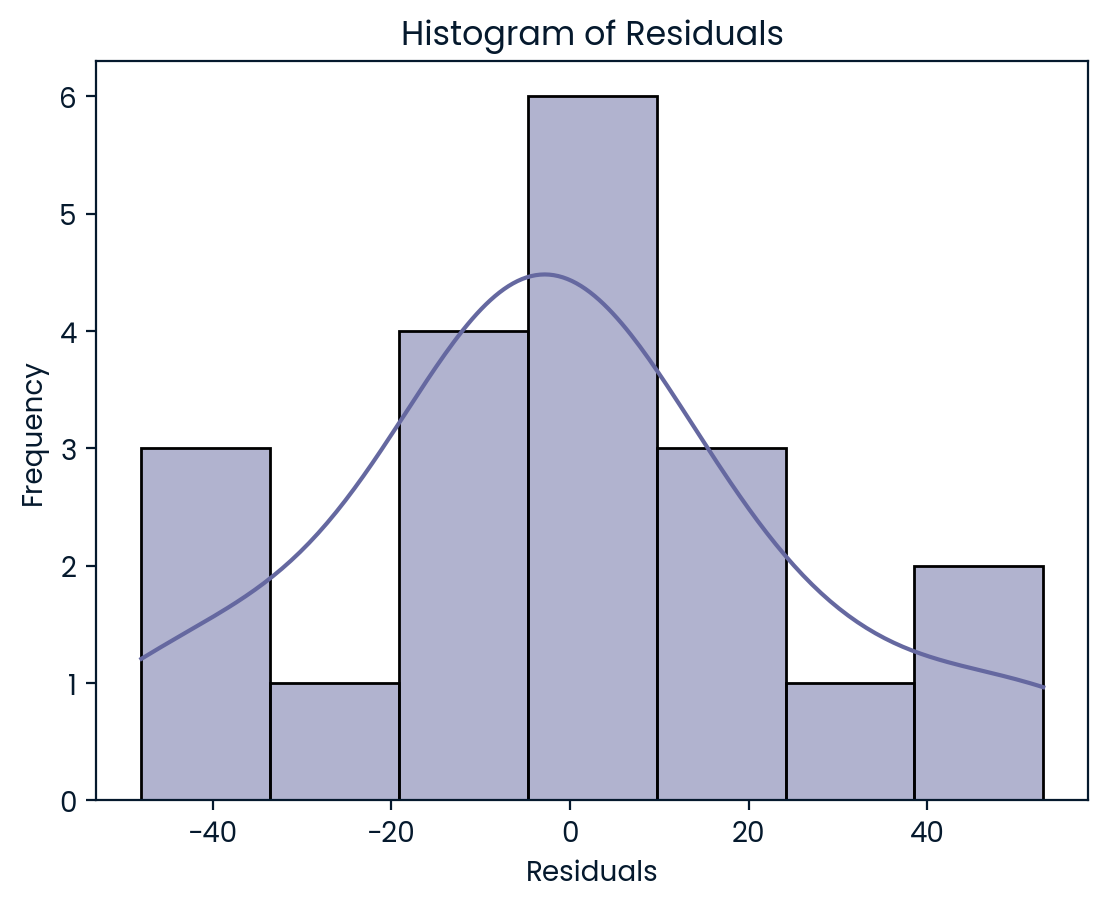

In [220]:
# Assuming 'differences' is the list of residuals you want to plot
sns.histplot(differences, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Conclusion:  
The residual plot is roughly normally distributed. However, there seem to be a large amount of residuals on either side of the graph. This means there are drastic over and underestimations for some teams. Maybe this trend can be dampened through using Year to predict GD.

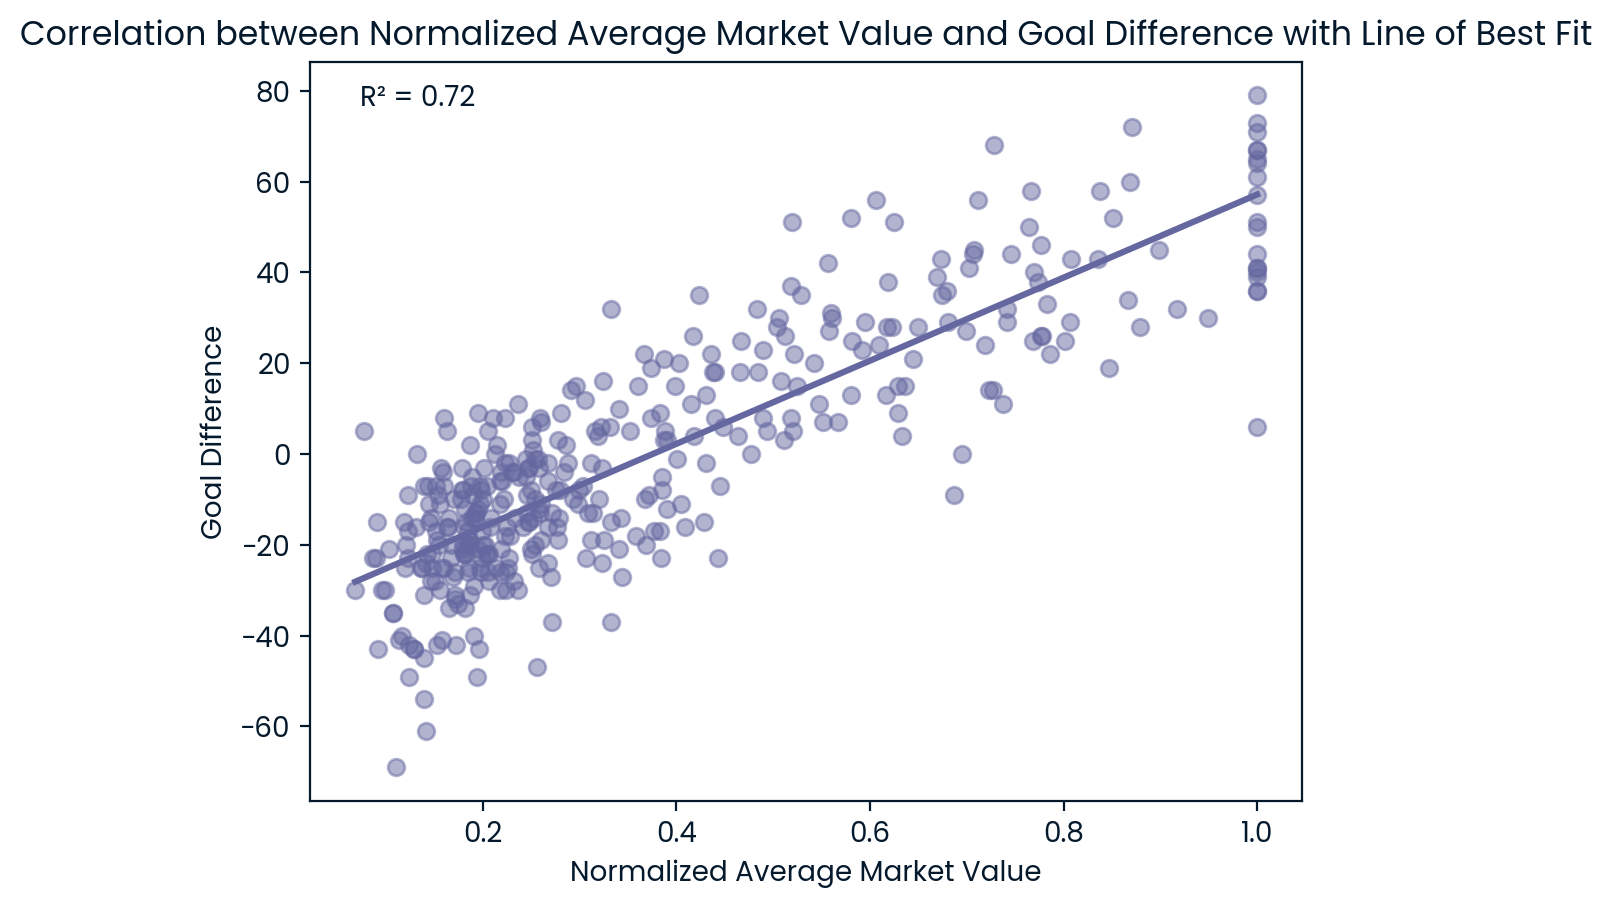

In [221]:
# Scatterplot with a regression line showing the correlation between Average Market Value and Points
sns.regplot(data=data, x="Normalized_Average_Market_Value", y="Goal_Difference", ci=None, scatter_kws={'alpha':0.5})
plt.title("Correlation between Normalized Average Market Value and Goal Difference with Line of Best Fit")
plt.xlabel("Normalized Average Market Value")
plt.ylabel("Goal Difference")

# Calculating and displaying the r-squared value
slope, intercept, r_value, p_value, std_err = linregress(data["Normalized_Average_Market_Value"], data["Goal_Difference"])
plt.text(0.05, 0.95, f'R² = {r_value**2:.2f}', ha='left', va='center', transform=plt.gca().transAxes)

plt.show()

This graph shows that there is a clear correlation between normalized average market value and goal difference. This is a good sign and hopefully we can create a better model to predict GD. Additionally, there seems to be a non-linear trend to this data which we will explore soon.

In [222]:
gd_data = data.drop(columns=["Position", "Points", "Average_Market_Value", "Year"])

#2004/05 season to the 2021/22 season
gd_data_wo_2022 = gd_data.head(len(gd_data) - 20)
gd_data_wo_2022

,Team,Goal_Difference,Normalized_Average_Market_Value
0,chelsea fc,57,1.000000
1,manchester united,32,0.741815
2,arsenal fc,51,0.624883
3,liverpool fc,11,0.547240
4,tottenham hotspur,6,0.321796
...,...,...,...
355,brentford fc,-8,0.279332
356,crystal palace,4,0.318959
357,norwich city,-61,0.141026
358,watford fc,-43,0.128982


In [223]:
gd_data_2223 = gd_data.tail(20)
gd_data_2223

,Team,Goal_Difference,Normalized_Average_Market_Value
360,manchester city,61,1.000000
361,arsenal fc,45,0.707122
362,chelsea fc,-9,0.686647
363,manchester united,15,0.524332
364,liverpool fc,28,0.617804
365,tottenham hotspur,7,0.566469
366,newcastle united,35,0.422849
367,brighton & hove albion,19,0.374184
368,aston villa,5,0.351632
369,wolverhampton wanderers,-27,0.343323


In [224]:
teams2223

['manchester city',
 'arsenal fc',
 'chelsea fc',
 'manchester united',
 'liverpool fc',
 'tottenham hotspur',
 'newcastle united',
 'brighton & hove albion',
 'aston villa',
 'wolverhampton wanderers',
 'leicester city',
 'west ham united',
 'southampton fc',
 'everton fc',
 'nottingham forest',
 'brentford fc',
 'leeds united',
 'crystal palace',
 'fulham fc',
 'afc bournemouth']

In [251]:
gd_namv_predictions = []
teams_std_dev = []
def gd_namv_prediction_model(num_degrees, std_dev, plots):
    gd_data_wo_2022 = data.drop(columns=["Position", "Points", "Average_Market_Value", "Year"]).head(len(gd_data) - 20)
    gd_namv_predictions.clear()
    teams_std_dev.clear()
    
    for i in range(20):
        team = teams2223[i]
        team_df = gd_data_wo_2022[gd_data_wo_2022['Team'] == team]

        degrees = 1
        if not team_df.empty: 
            team_std_dev = team_df['Goal_Difference'].std()
            teams_std_dev.append(team_std_dev)

            if(team_std_dev > std_dev):
                    degrees = num_degrees

            x = team_df['Normalized_Average_Market_Value']
            y = team_df['Goal_Difference']

            x = x.values.reshape(-1,1)
            y = y.values.reshape(-1,1)

            poly = PolynomialFeatures(degree= degrees, include_bias=False)
            poly_features = poly.fit_transform(x)
            poly_reg_model = LinearRegression()
            poly_reg_model.fit(poly_features, y)

            y_predicted = poly_reg_model.predict(poly_features)

            predictions = poly_reg_model.predict(poly_features)

            namv = [[gd_data_wo_2022["Normalized_Average_Market_Value"][i]]]
            poly23 = poly_features = poly.fit_transform(namv)
            gd_namv_predictions.append(poly_reg_model.predict(poly23))
            gd_namv_predictions[i] = gd_namv_predictions[i][0][0].round()
            
            if(plots):
                print(team)
                print("Standard Deviation:", team_std_dev)
                print("y(" + str(gd_data_wo_2022["Normalized_Average_Market_Value"][i]) + ") =", gd_namv_predictions[i])
                print("_____________________________")

                plt.scatter(x, y, color = 'purple')
                plt.plot(x, y_predicted, color = 'green', linewidth = 3)
                plt.xlabel("Normalized Average Market Value (namv)")
                plt.ylabel("Goal Difference")
                plt.show()

        else: 
            gd_namv_predictions.append(-30)
            teams_std_dev.append(0)
            #print(team)
            #print("No data for this team!")
            #print("_____________________________")

In [226]:
teams_gd_year_df

,Team,Goal_Difference,Predicted_Goal_Difference,Residual
360,manchester city,61,60.0,1.0
361,arsenal fc,45,14.0,31.0
362,chelsea fc,-9,36.0,-45.0
363,manchester united,15,21.0,-6.0
364,liverpool fc,28,76.0,-48.0
365,tottenham hotspur,7,16.0,-9.0
366,newcastle united,35,-18.0,53.0
367,brighton & hove albion,19,3.0,16.0
368,aston villa,5,39.0,-34.0
369,wolverhampton wanderers,-27,-26.0,-1.0


In [227]:
#degree of 1
degrees = 1
std_dev = -1 #it doesnt matter because either way its 1 degree
gd_namv_prediction_model(degrees, std_dev, False)

#create df
teams_gd_namv_df = pd.DataFrame({'Team': teams2223, 'Goal_Difference': gd_data_2223["Goal_Difference"], 'Predicted_Goal_Difference': gd_namv_predictions})

#calculate difference
diff = 0
for team in range(20):
    diff += abs(teams_gd_namv_df["Goal_Difference"].iloc[team]  -teams_gd_namv_df["Predicted_Goal_Difference"].iloc[team]) 
diff /= 20

#------------------------------------------------------------------------------------------------------

#show results
print("degrees:", degrees,  "----> error: ", diff)
        
for degrees in range(2, 4):
    print("----------------------------------------------------")
    for std_dev in [8,10,12,14,16,18,20]:
        #create predictions
        gd_namv_prediction_model(degrees, std_dev, False)

        #create df
        teams_gd_namv_df = pd.DataFrame({'Team': teams2223, 'Goal_Difference': gd_data_2223["Goal_Difference"], 'Predicted_Goal_Difference': gd_namv_predictions})

        #calculate difference
        diff = 0
        for team in range(20):
            diff += abs(teams_gd_namv_df["Goal_Difference"].iloc[team]  - teams_gd_namv_df["Predicted_Goal_Difference"].iloc[team]) 
        diff /= 20

        #show results
        print("degrees:", degrees, "| std_dev:", std_dev, "----> error: ", diff)

degrees: 1 ----> error:  17.05
----------------------------------------------------
degrees: 2 | std_dev: 8 ----> error:  19.3
degrees: 2 | std_dev: 10 ----> error:  19.25
degrees: 2 | std_dev: 12 ----> error:  19.25
degrees: 2 | std_dev: 14 ----> error:  19.7
degrees: 2 | std_dev: 16 ----> error:  19.8
degrees: 2 | std_dev: 18 ----> error:  16.2
degrees: 2 | std_dev: 20 ----> error:  17.0
----------------------------------------------------
degrees: 3 | std_dev: 8 ----> error:  30.5
degrees: 3 | std_dev: 10 ----> error:  30.75
degrees: 3 | std_dev: 12 ----> error:  30.8
degrees: 3 | std_dev: 14 ----> error:  28.05
degrees: 3 | std_dev: 16 ----> error:  28.15
degrees: 3 | std_dev: 18 ----> error:  19.75
degrees: 3 | std_dev: 20 ----> error:  17.0


This tells us that using namv is best to predict goal difference when we create a regression model with a degree of **2** for teams with a standard deviation of over **18** in their GD data for the last 20 or so years with respect to minimizing average error. Tweaking these values will give us various degrees of error.

manchester city
Standard Deviation: 30.100919578596336
y(1.0) = 60.0
_____________________________


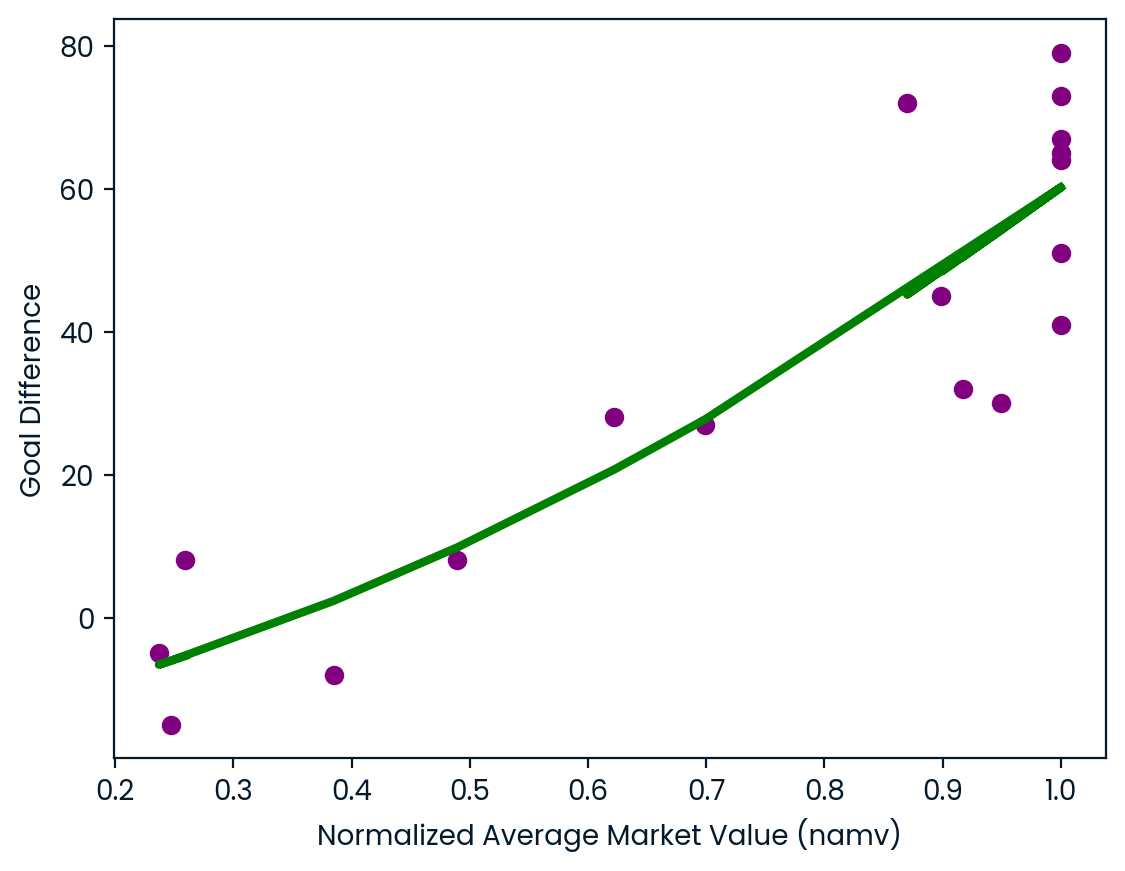

arsenal fc
Standard Deviation: 10.780186375970203
y(0.7418147801683816) = 34.0
_____________________________


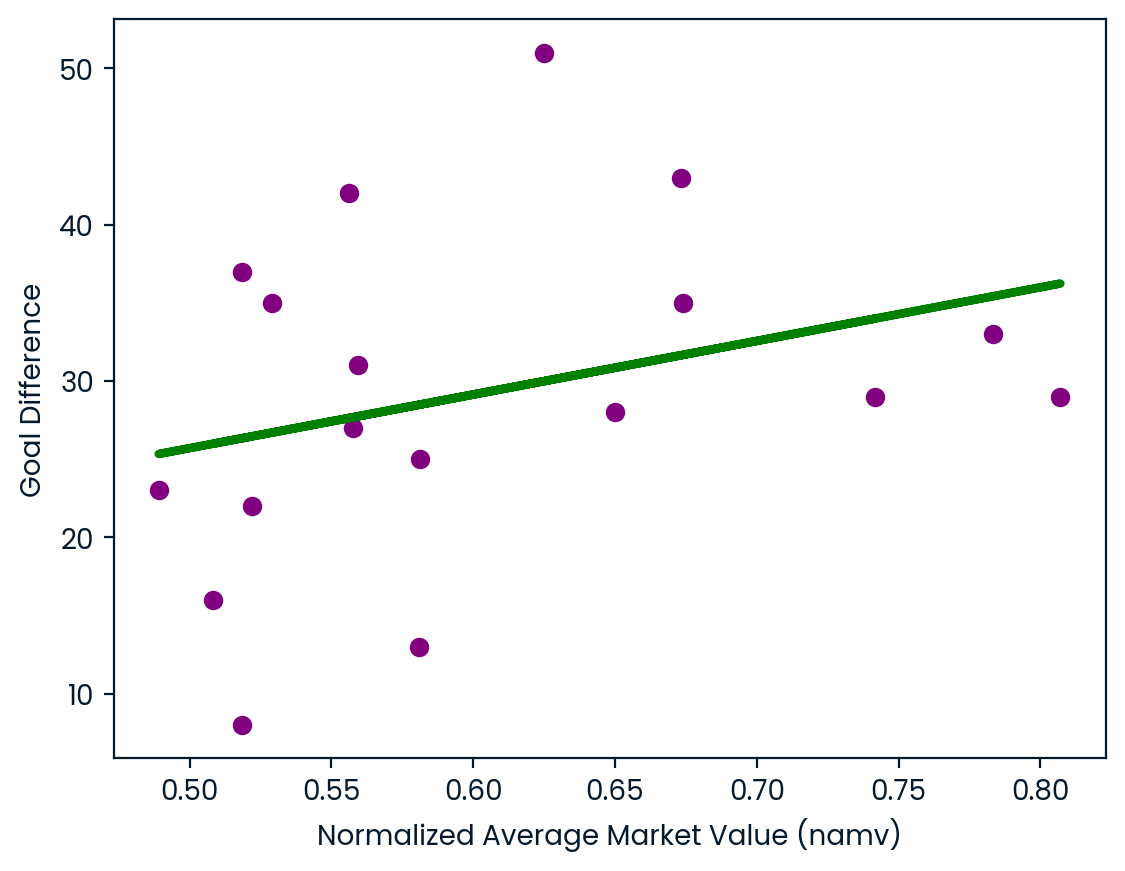

chelsea fc
Standard Deviation: 16.172780327742405
y(0.6248830682881198) = 24.0
_____________________________


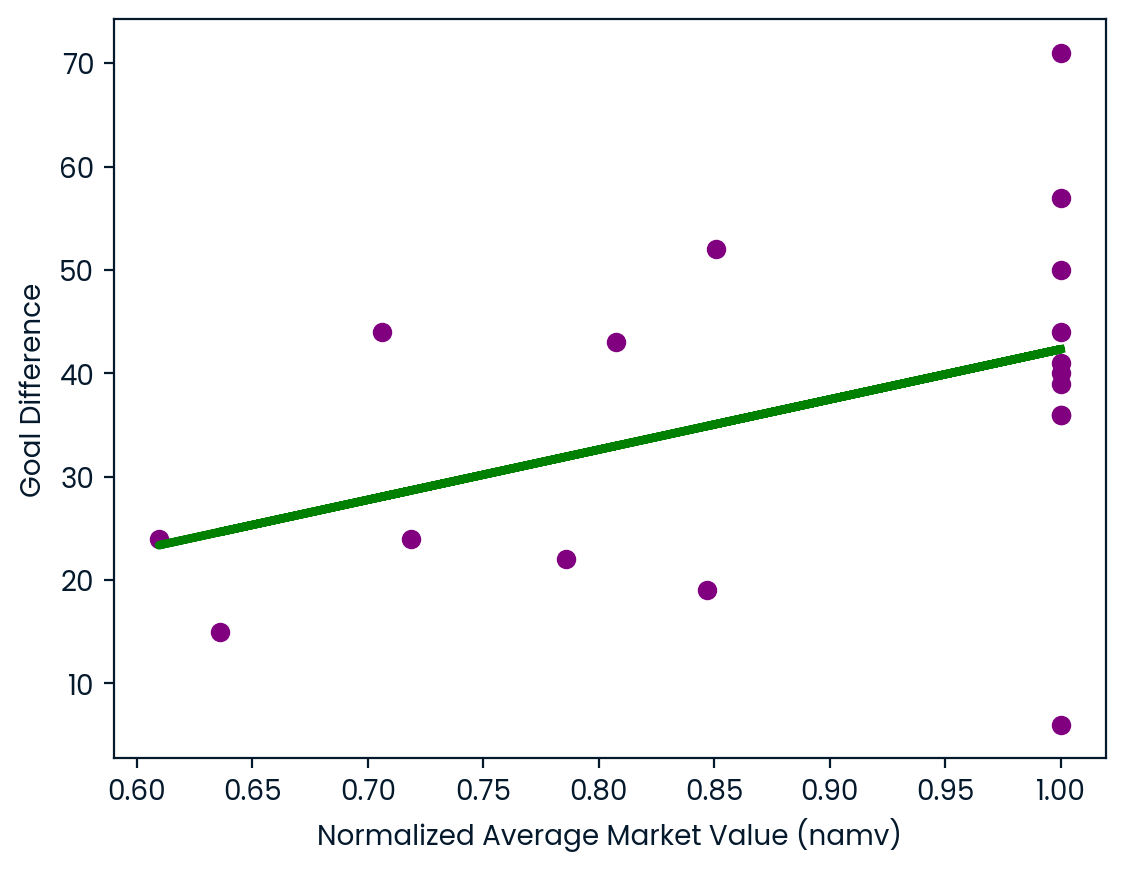

manchester united
Standard Deviation: 16.905446390056042
y(0.5472404115996258) = 29.0
_____________________________


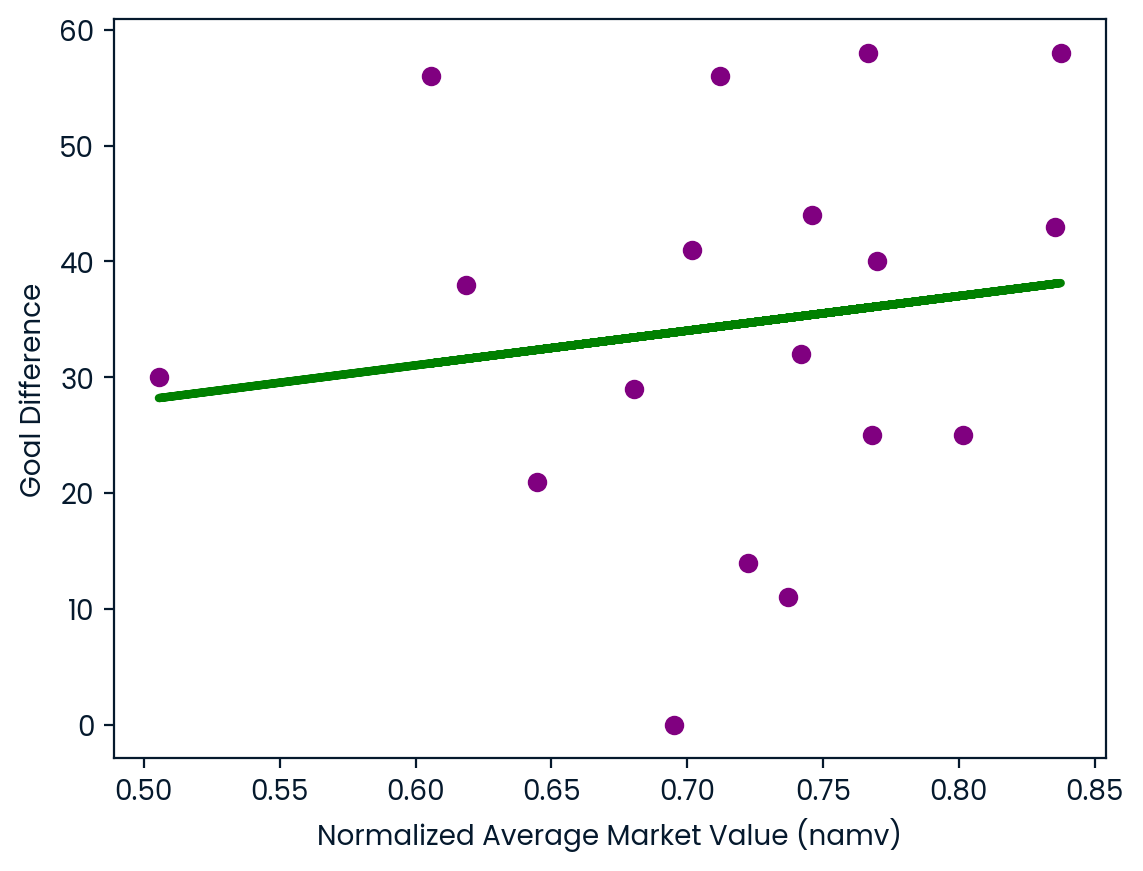

liverpool fc
Standard Deviation: 19.43961658084998
y(0.3217960710944808) = 36.0
_____________________________


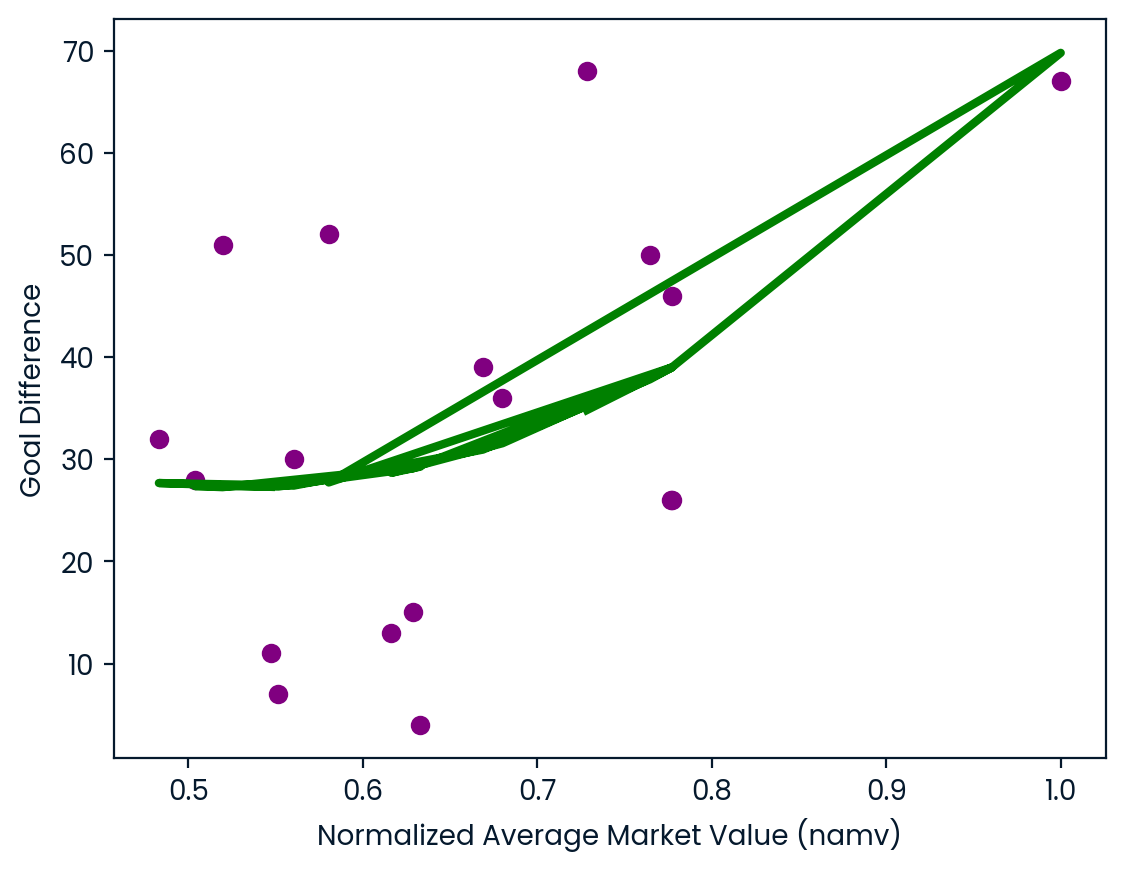

tottenham hotspur
Standard Deviation: 15.518068743124573
y(0.3676333021515435) = 5.0
_____________________________


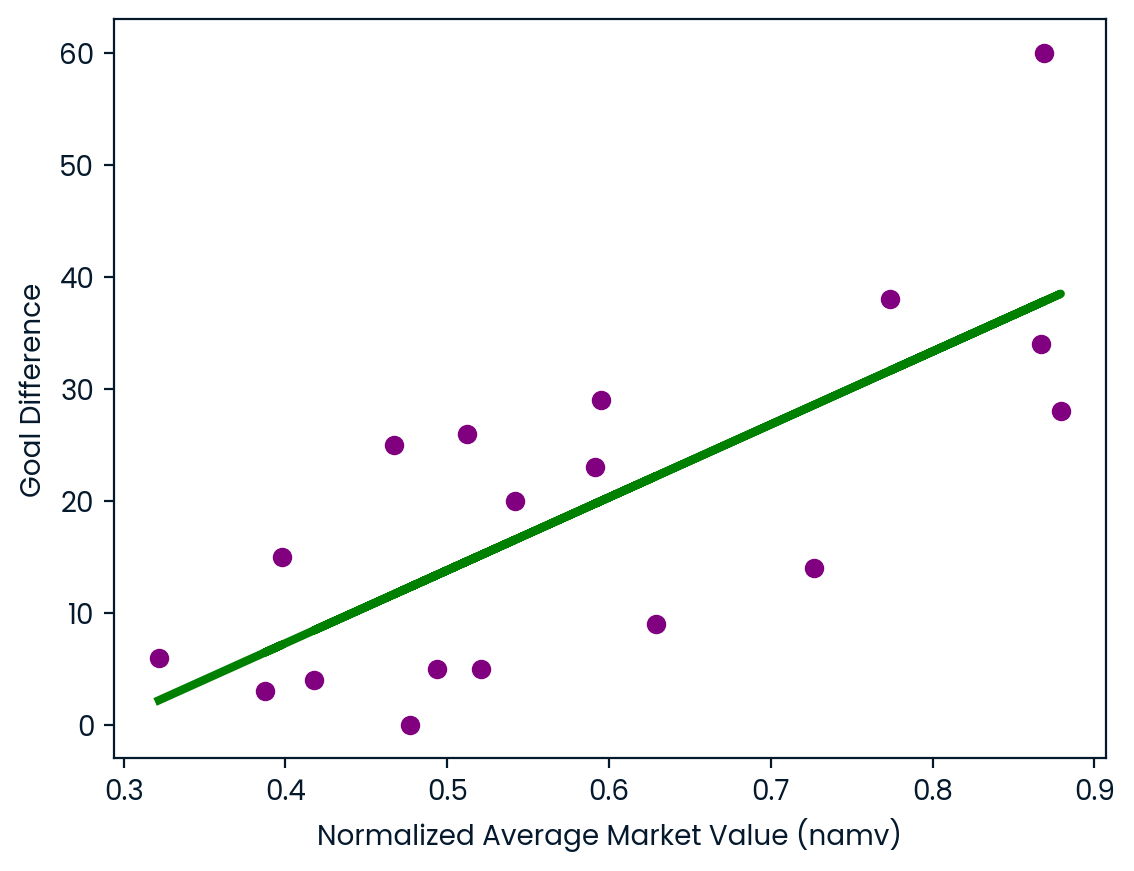

newcastle united
Standard Deviation: 9.409215341001254
y(0.2675397567820393) = -13.0
_____________________________


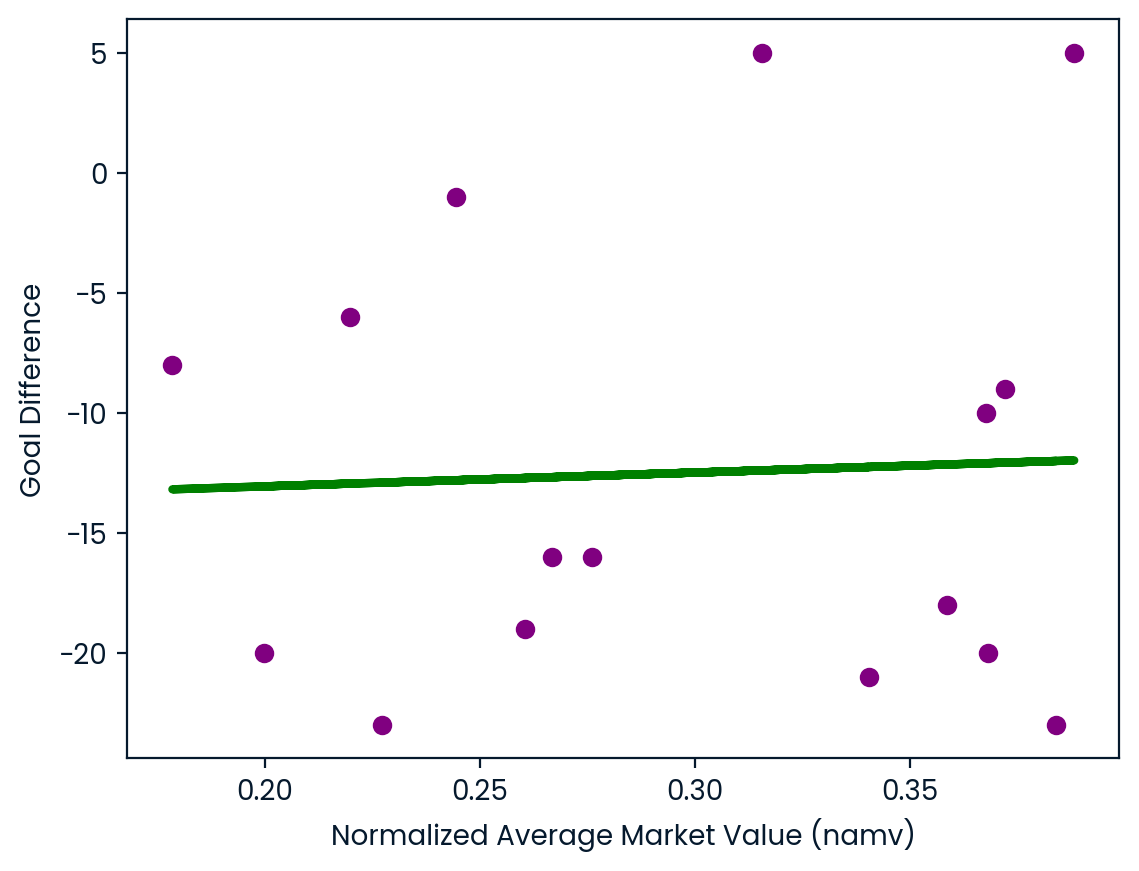

brighton & hove albion
Standard Deviation: 9.555103348473004
y(0.2591206735266604) = -5.0
_____________________________


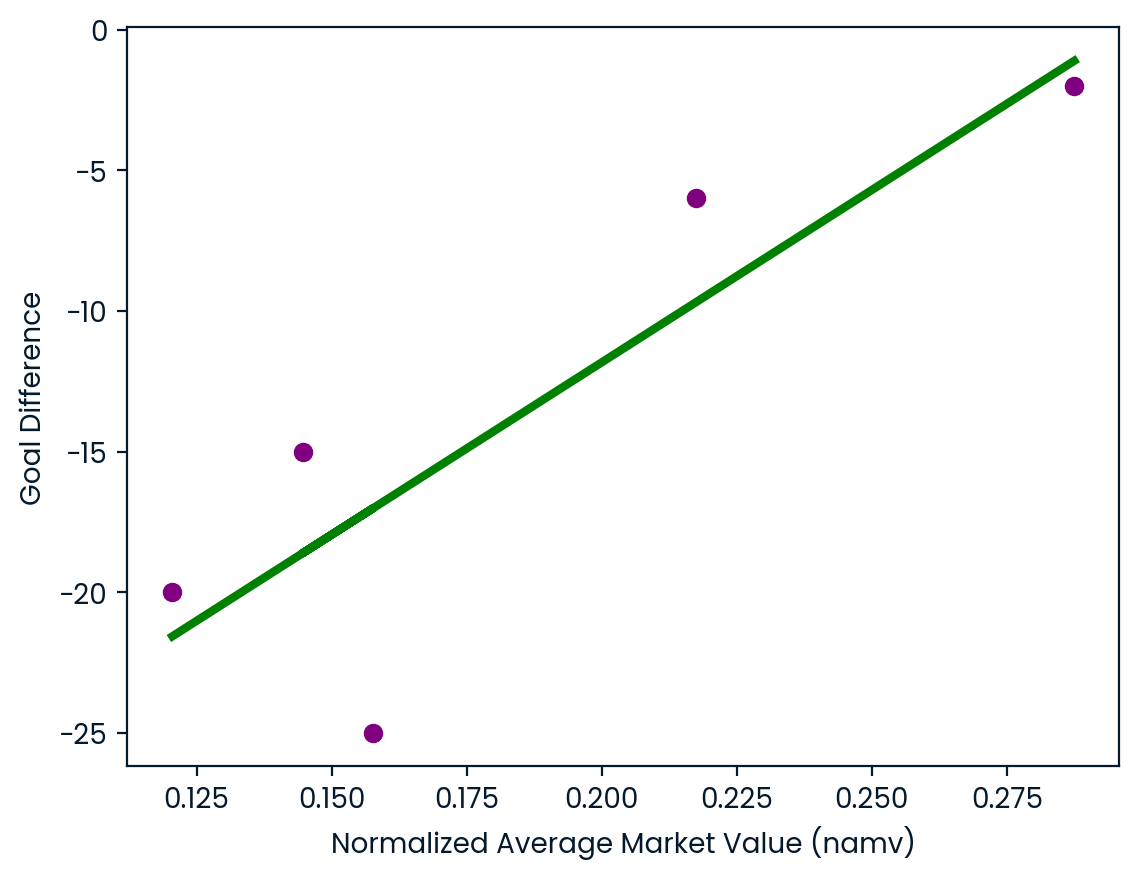

aston villa
Standard Deviation: 18.18083763589723
y(0.2600561272217025) = -9.0
_____________________________


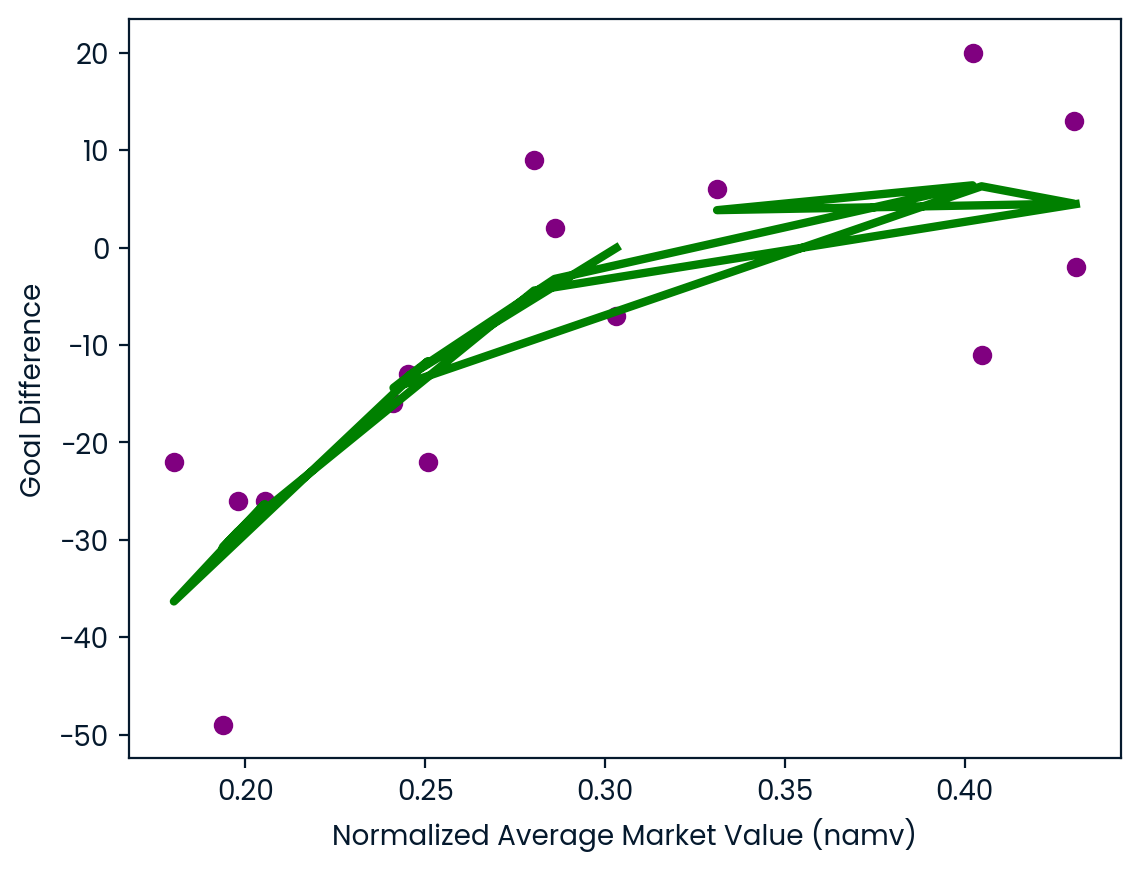

wolverhampton wanderers
Standard Deviation: 17.577041302573676
y(0.1945743685687558) = -17.0
_____________________________


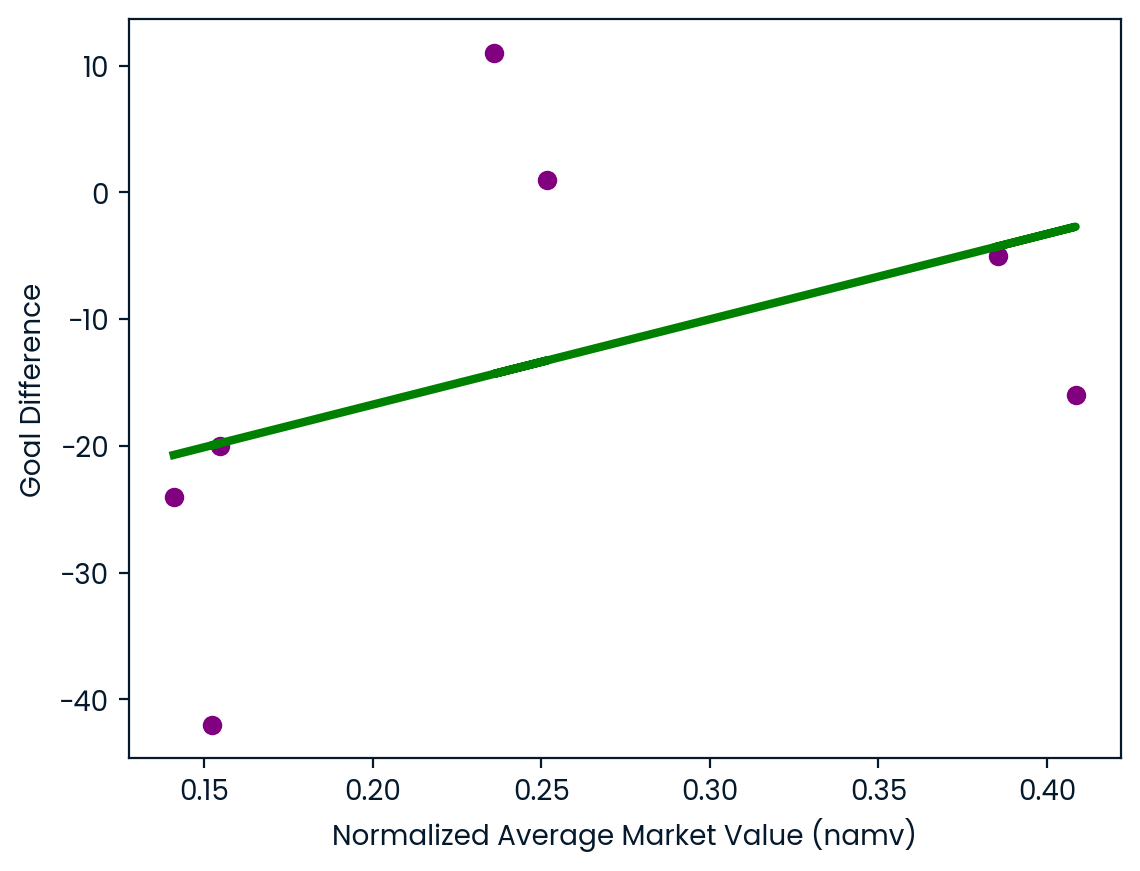

leicester city
Standard Deviation: 16.90097207686165
y(0.3030869971936389) = 4.0
_____________________________


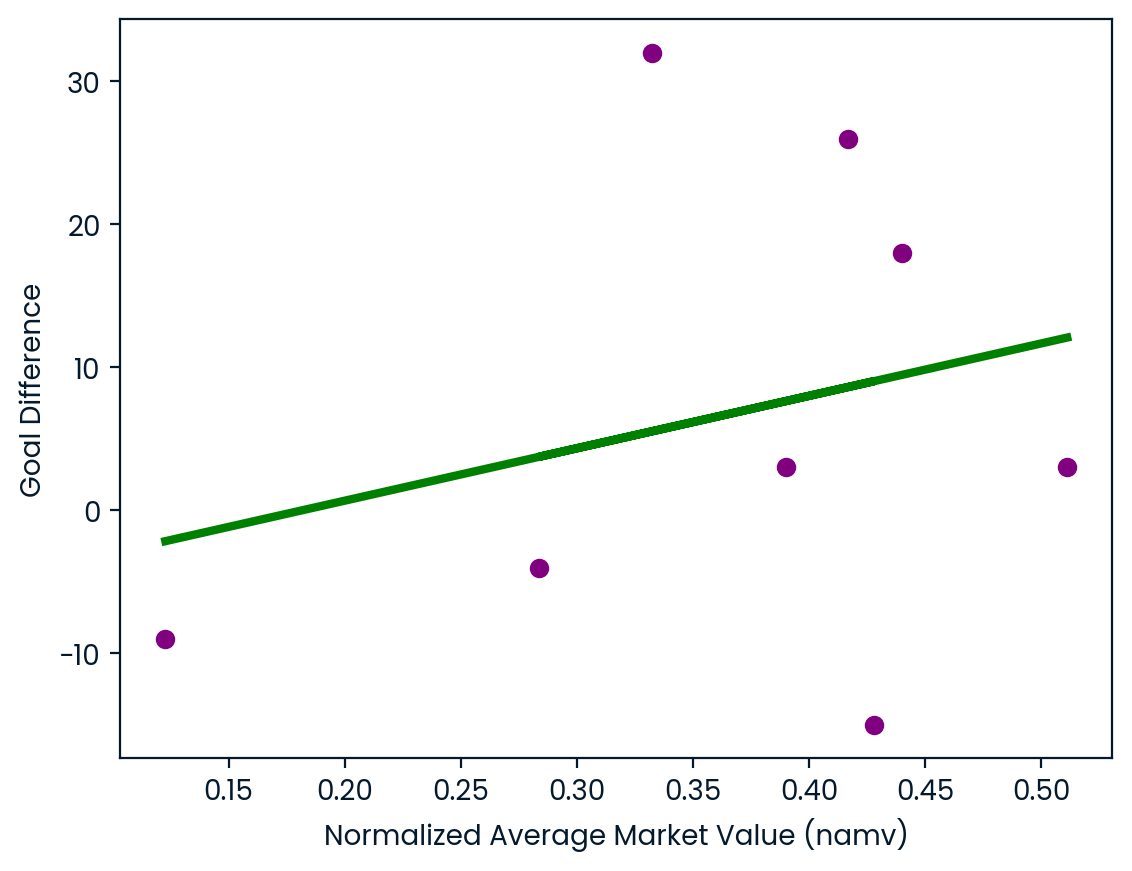

west ham united
Standard Deviation: 12.638400478963572
y(0.2572497661365762) = -8.0
_____________________________


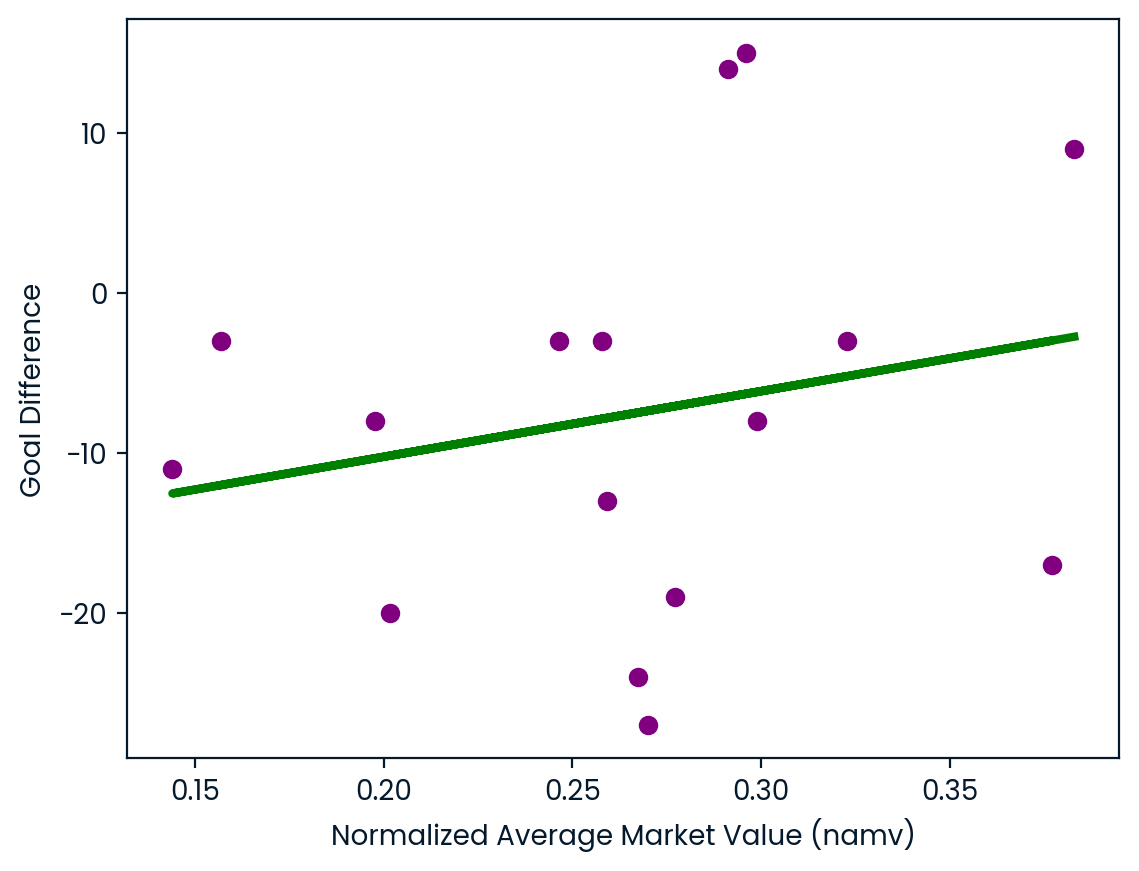

southampton fc
Standard Deviation: 16.25478950396411
y(0.1973807296538821) = -15.0
_____________________________


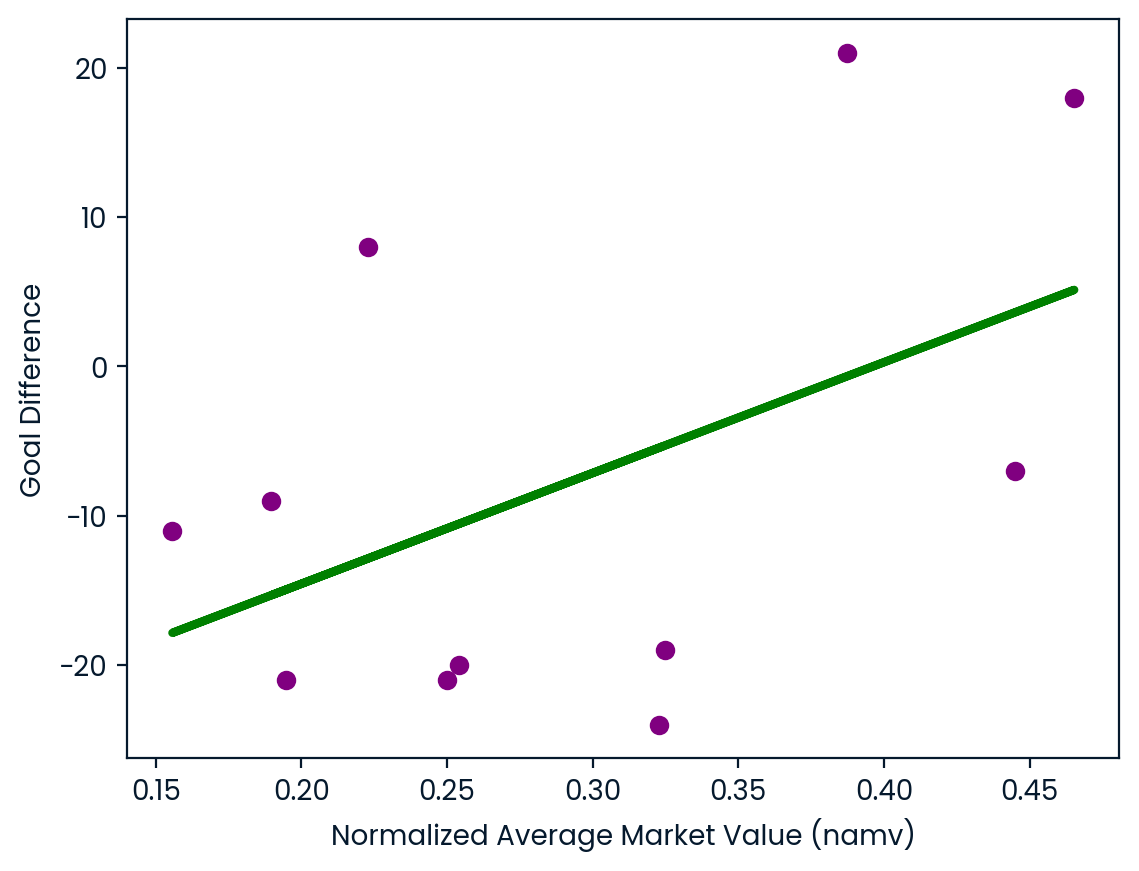

everton fc
Standard Deviation: 13.634826611733137
y(0.1796071094480823) = -9.0
_____________________________


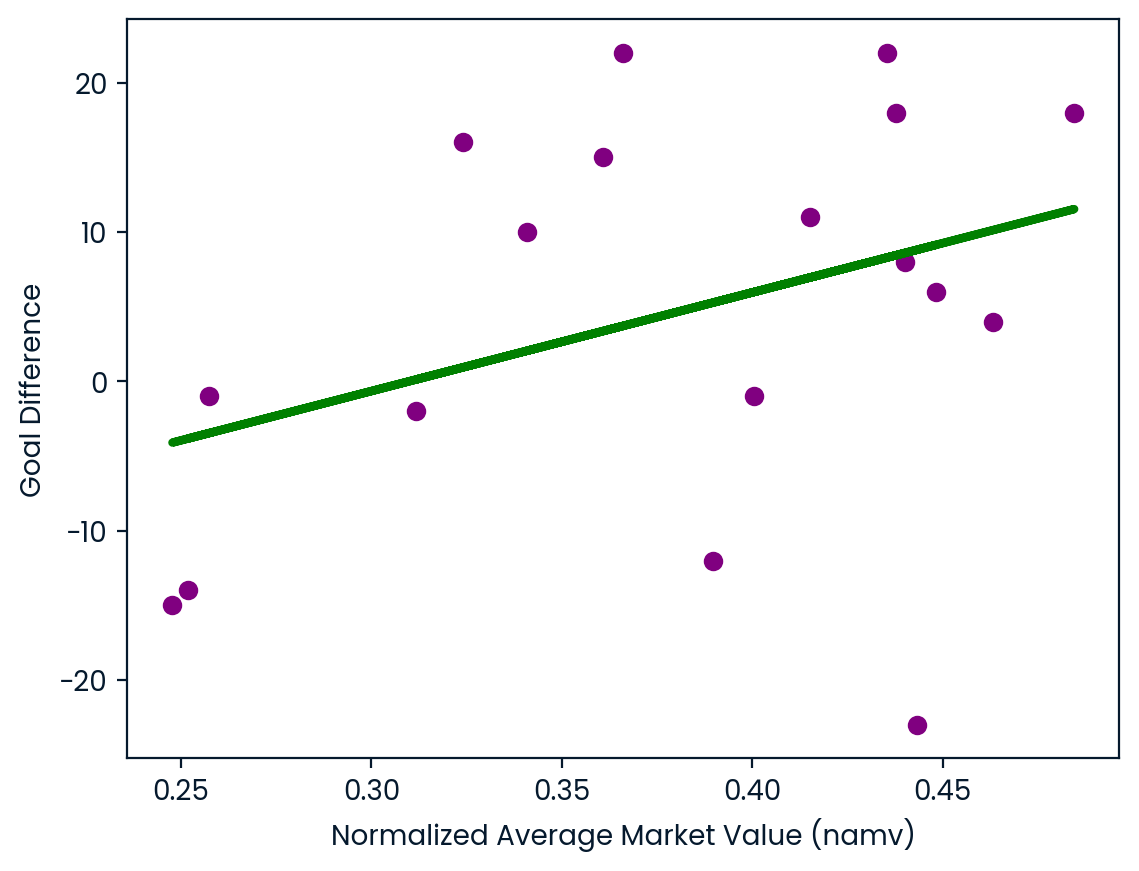

brentford fc
Standard Deviation: nan
y(0.1637043966323667) = -8.0
_____________________________


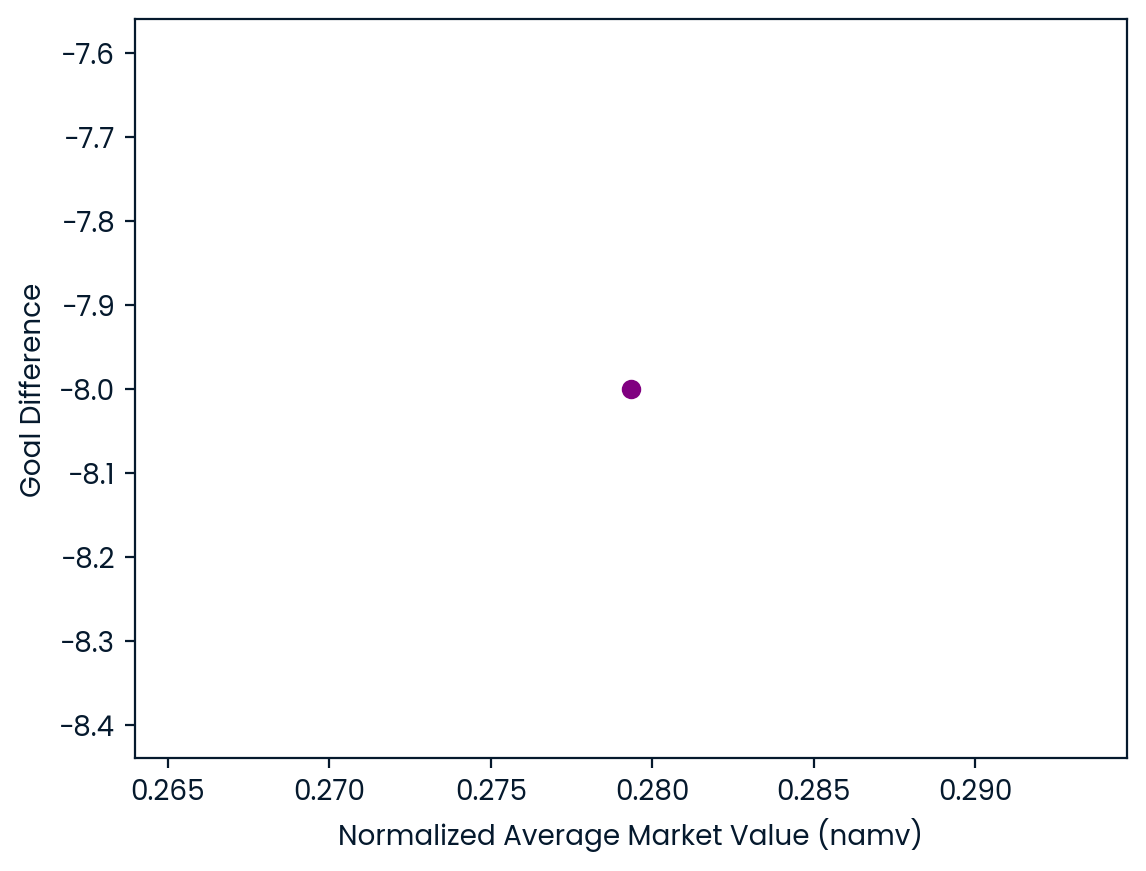

leeds united
Standard Deviation: 31.81980515339464
y(0.2076707202993452) = 9.0
_____________________________


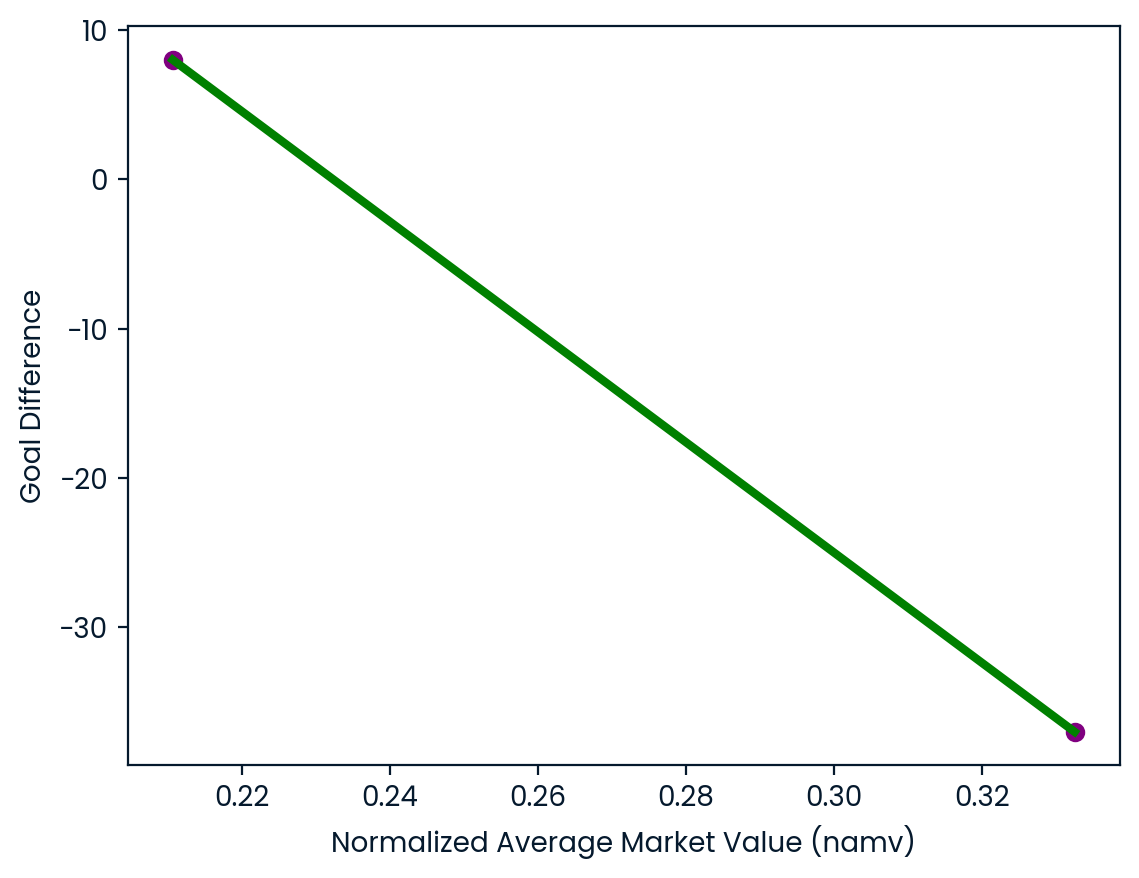

crystal palace
Standard Deviation: 9.019115502334165
y(0.1478016838166511) = -15.0
_____________________________


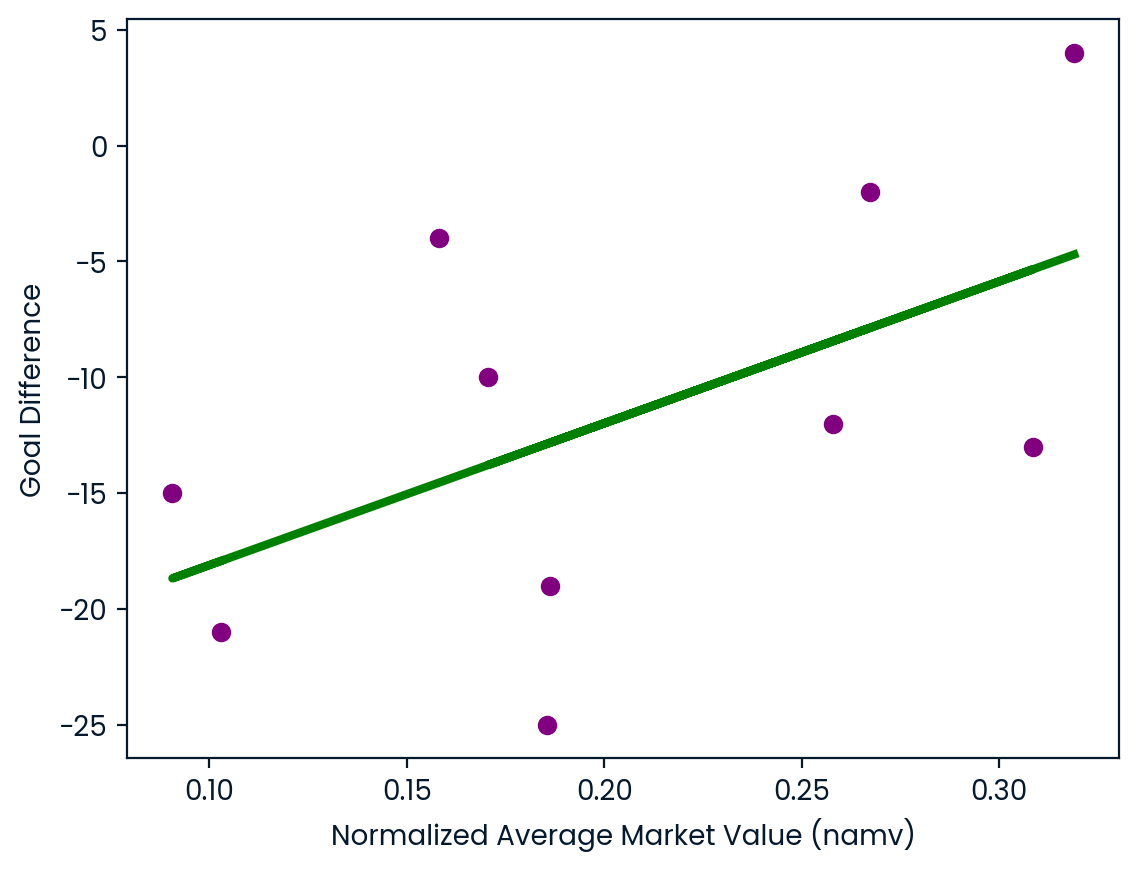

fulham fc
Standard Deviation: 17.279125609190466
y(0.1028999064546305) = -15.0
_____________________________


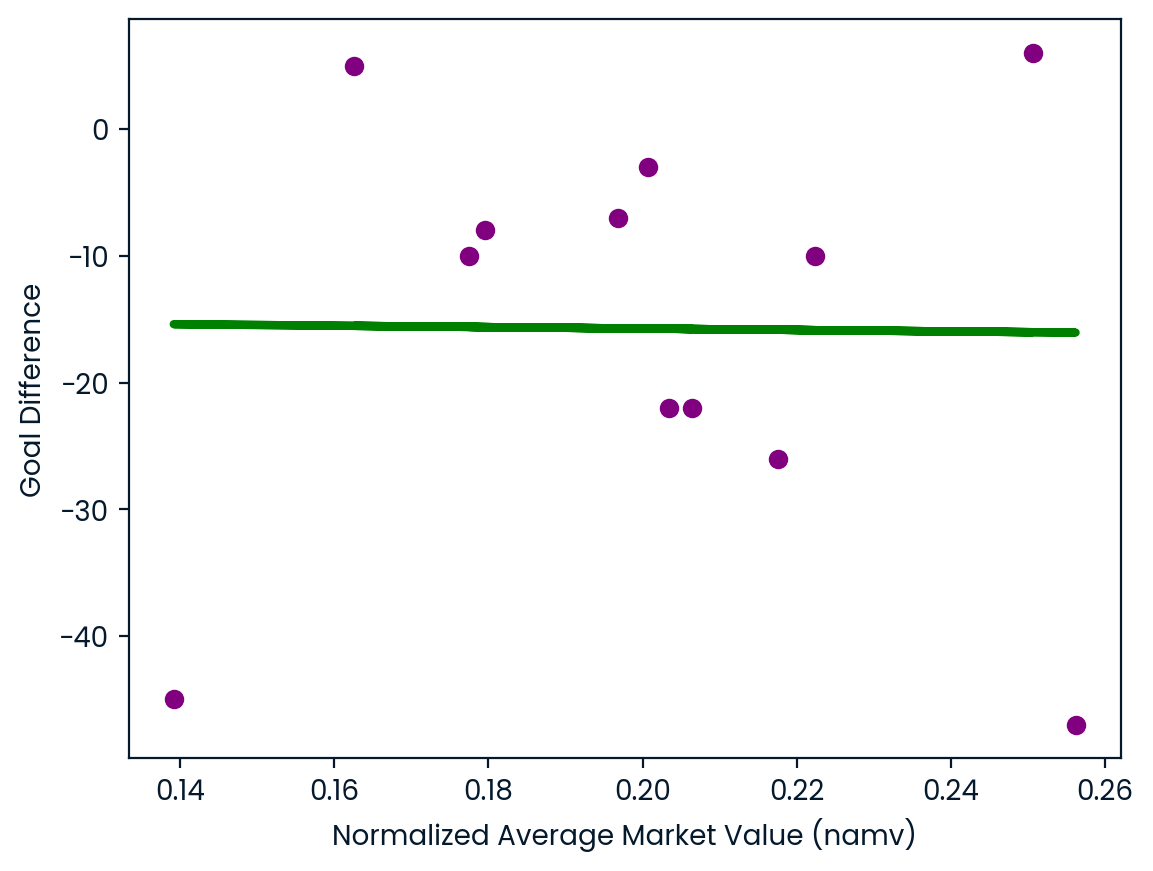

afc bournemouth
Standard Deviation: 5.495452665613635
y(0.1075771749298409) = -19.0
_____________________________


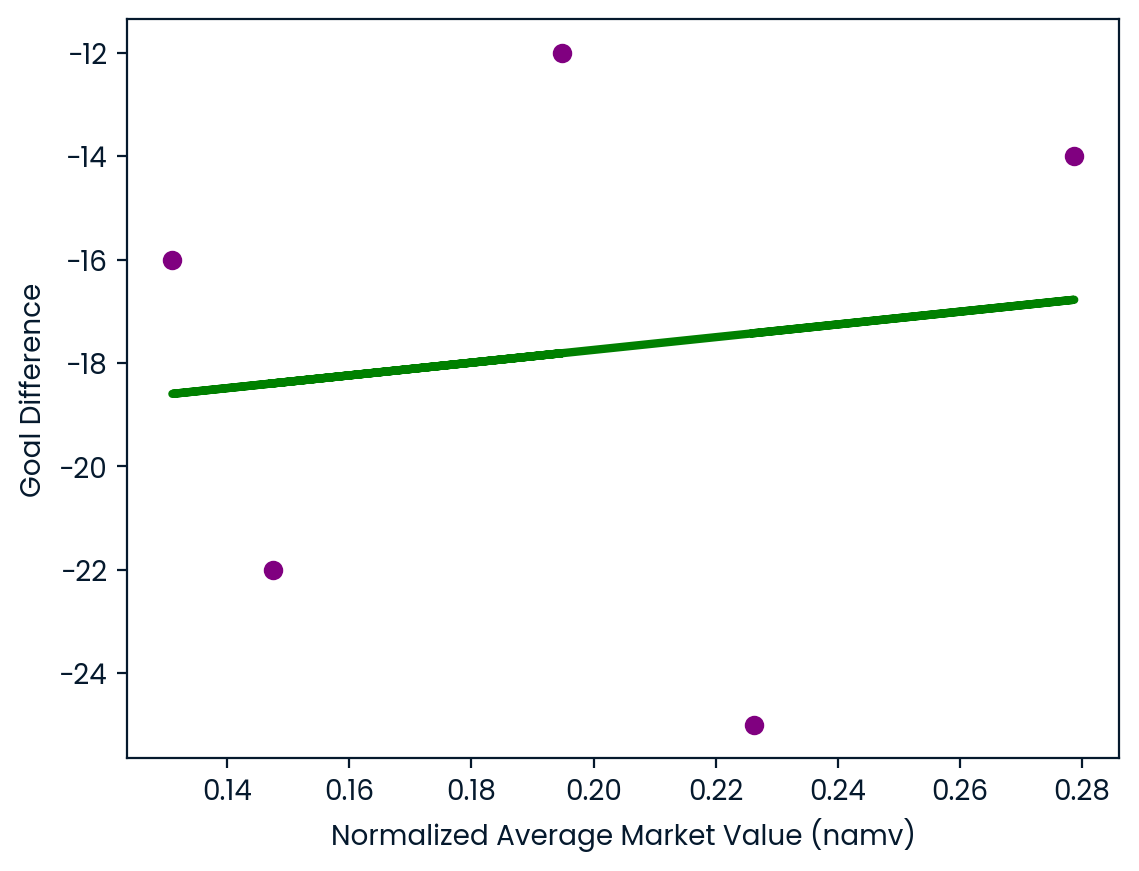

In [228]:
degrees = 2
std_dev = 18
residuals = []
gd_namv_prediction_model(degrees, std_dev, True)

#create df
teams_gd_namv_df = pd.DataFrame({'Team': teams2223, 'Goal_Difference': gd_data_2223["Goal_Difference"], 'Predicted_Goal_Difference': gd_namv_predictions})

#calculate difference
diff = 0
for team in range(20):
    real_diff = teams_gd_namv_df["Goal_Difference"].iloc[team]  -teams_gd_namv_df["Predicted_Goal_Difference"].iloc[team]
    residuals.append(real_diff)
    diff += abs(real_diff)
diff /= 20

#add it to the dataframe
teams_gd_namv_df["Residual"] = residuals

In [229]:
teams_gd_namv_df

,Team,Goal_Difference,Predicted_Goal_Difference,Residual
360,manchester city,61,60.0,1.0
361,arsenal fc,45,34.0,11.0
362,chelsea fc,-9,24.0,-33.0
363,manchester united,15,29.0,-14.0
364,liverpool fc,28,36.0,-8.0
365,tottenham hotspur,7,5.0,2.0
366,newcastle united,35,-13.0,48.0
367,brighton & hove albion,19,-5.0,24.0
368,aston villa,5,-9.0,14.0
369,wolverhampton wanderers,-27,-17.0,-10.0


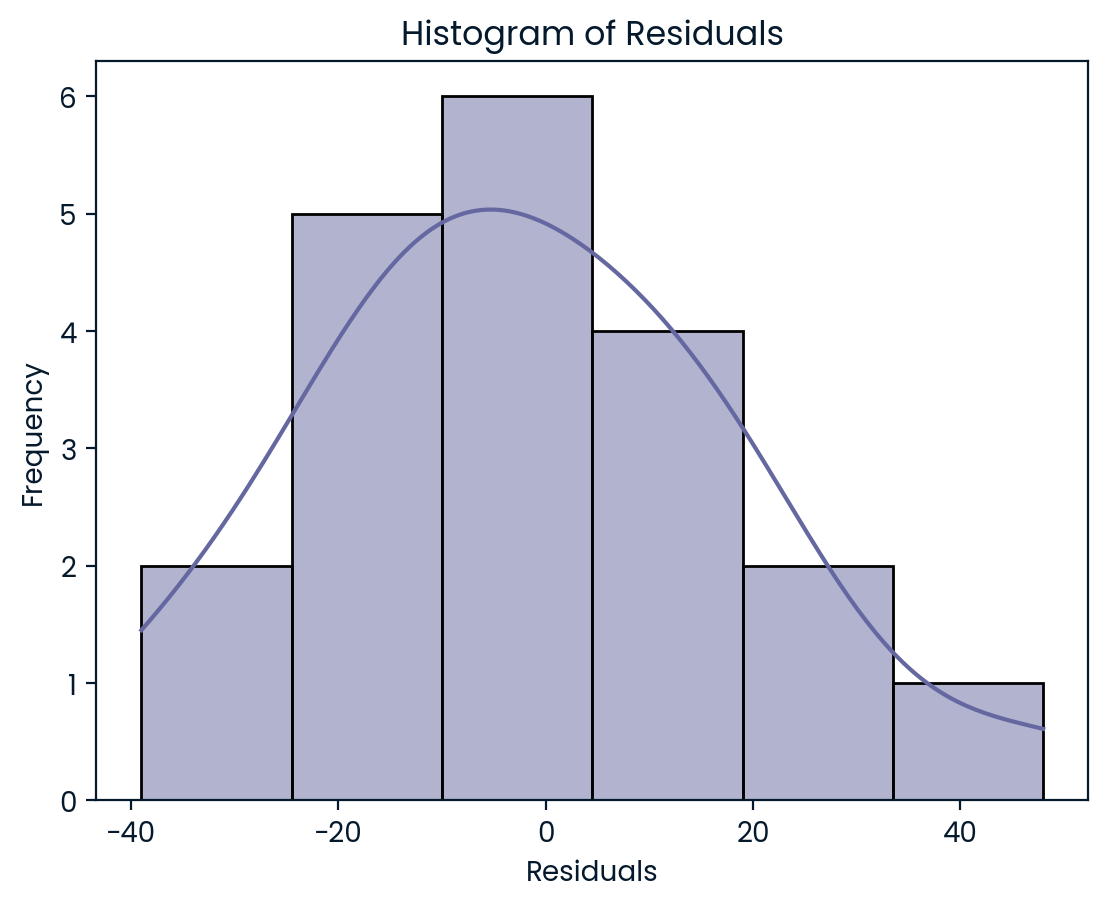

In [230]:
# Assuming 'differences' is the list of residuals you want to plot
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Using NAMV to predict GD has a better accuracy (~16.2 goals vs ~19.1 goals) and its residuals are randomly scattered. This is a good sign but it may be better to combine these two inputs (NAMV and Year) and make a multiple regression model to predict GD as NAMV has low frequency for extreme residuals (residuals on either side of the graph) while Year has high residuals for those values. 

In [231]:
#create big df that shows both predictions
teams_gd_predictions_df = pd.DataFrame(
    {'Team': teams2223, 
     'Real_GD': gd_data_2223["Goal_Difference"], 
     'Namv_GD': gd_namv_predictions,
     'Year_GD': gd_year_predictions,
     'GD_Std_Dev' : teams_std_dev,
     'Namv_GD_Residual' : teams_gd_namv_df["Residual"],
     'Year_GD_Residual' : teams_gd_year_df["Residual"],
    })
teams_gd_predictions_df

,Team,Real_GD,Namv_GD,Year_GD,GD_Std_Dev,Namv_GD_Residual,Year_GD_Residual
360,manchester city,61,60.0,60.0,30.100920,1.0,1.0
361,arsenal fc,45,34.0,14.0,10.780186,11.0,31.0
362,chelsea fc,-9,24.0,36.0,16.172780,-33.0,-45.0
363,manchester united,15,29.0,21.0,16.905446,-14.0,-6.0
364,liverpool fc,28,36.0,76.0,19.439617,-8.0,-48.0
365,tottenham hotspur,7,5.0,16.0,15.518069,2.0,-9.0
366,newcastle united,35,-13.0,-18.0,9.409215,48.0,53.0
367,brighton & hove albion,19,-5.0,3.0,9.555103,24.0,16.0
368,aston villa,5,-9.0,39.0,18.180838,14.0,-34.0
369,wolverhampton wanderers,-27,-17.0,-26.0,17.577041,-10.0,-1.0


If we had to use one input to predict GD, it would be NAMV. However, the idea of using two may be better. Lets evaluate if this may be the case.

In [232]:
mixed_residual = []
is_combining_better = []

for i in range(len(teams_gd_predictions_df)):
    namv_prediction = teams_gd_predictions_df["Namv_GD_Residual"].iloc[i]
    year_prediction = teams_gd_predictions_df["Year_GD_Residual"].iloc[i]
    mixed_res = (namv_prediction + year_prediction) / 2
    mixed_residual.append(mixed_res)
    
    if abs(mixed_res) < abs(namv_prediction):
        is_combining_better.append(True)
    else:
        is_combining_better.append(False)
    
teams_gd_predictions_df["Mixed_Residual"] = mixed_residual
teams_gd_predictions_df["Is_Combining_Better"] = is_combining_better

In [233]:
teams_gd_predictions_df

,Team,Real_GD,Namv_GD,Year_GD,GD_Std_Dev,Namv_GD_Residual,Year_GD_Residual,Mixed_Residual,Is_Combining_Better
360,manchester city,61,60.0,60.0,30.100920,1.0,1.0,1.0,False
361,arsenal fc,45,34.0,14.0,10.780186,11.0,31.0,21.0,False
362,chelsea fc,-9,24.0,36.0,16.172780,-33.0,-45.0,-39.0,False
363,manchester united,15,29.0,21.0,16.905446,-14.0,-6.0,-10.0,True
364,liverpool fc,28,36.0,76.0,19.439617,-8.0,-48.0,-28.0,False
365,tottenham hotspur,7,5.0,16.0,15.518069,2.0,-9.0,-3.5,False
366,newcastle united,35,-13.0,-18.0,9.409215,48.0,53.0,50.5,False
367,brighton & hove albion,19,-5.0,3.0,9.555103,24.0,16.0,20.0,True
368,aston villa,5,-9.0,39.0,18.180838,14.0,-34.0,-10.0,True
369,wolverhampton wanderers,-27,-17.0,-26.0,17.577041,-10.0,-1.0,-5.5,True


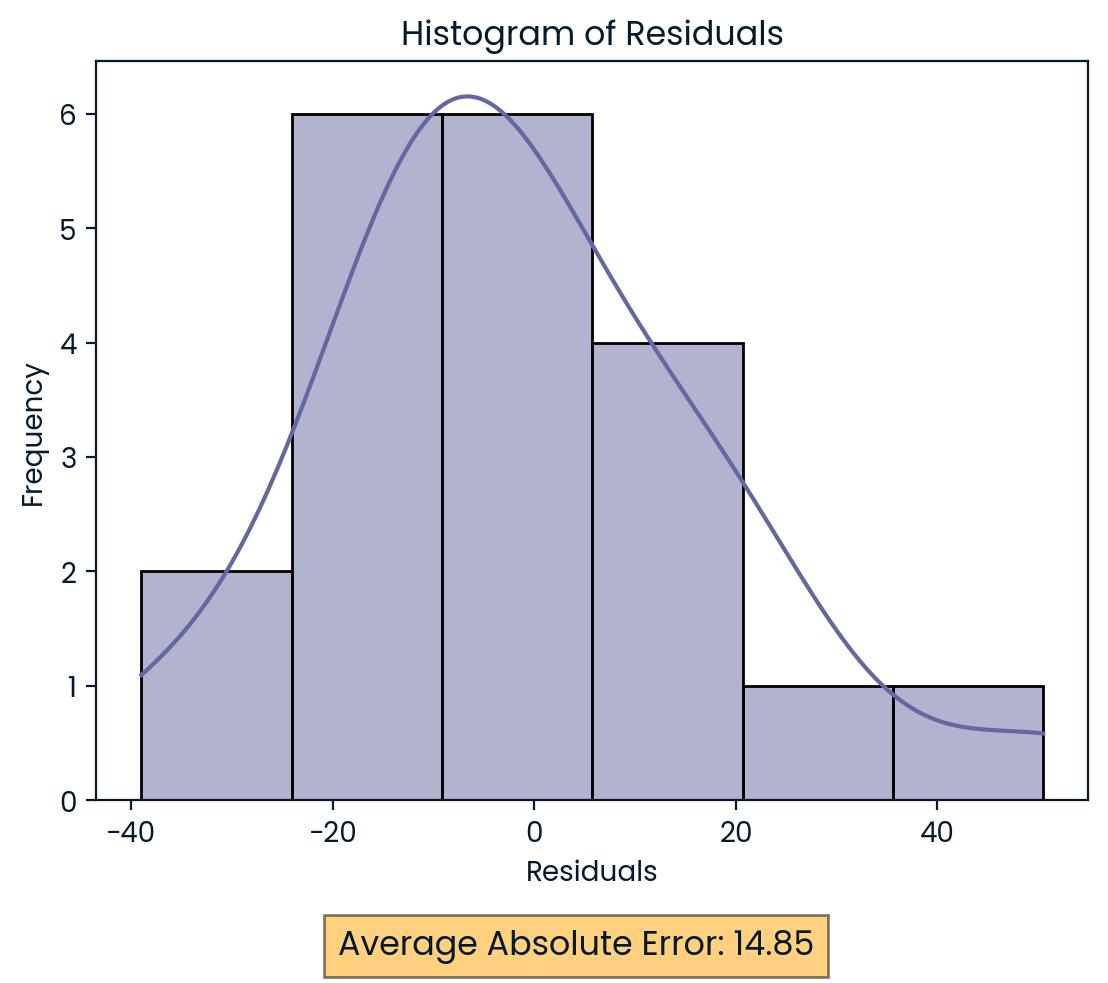

In [234]:
#calculate difference
error_sum = 0
for i in range(20):
    error_sum += abs(teams_gd_predictions_df["Mixed_Residual"].iloc[i])
error_sum /= 20

residuals = teams_gd_predictions_df["Mixed_Residual"].tolist()
# Plotting the histogram of residuals
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Adding the error sum to the graph
plt.figtext(0.5, -0.05, f'Average Absolute Error: {error_sum:.2f}', ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

plt.show()

This shows that combining Year and NAMV to predict GD may improve the GD predictions but there isn't much of a difference. Finally, a last question I want to test is if GD_Std_Dev and the Residuals have a correlation to make sure this isnt something I've incorrectly analyzed. 

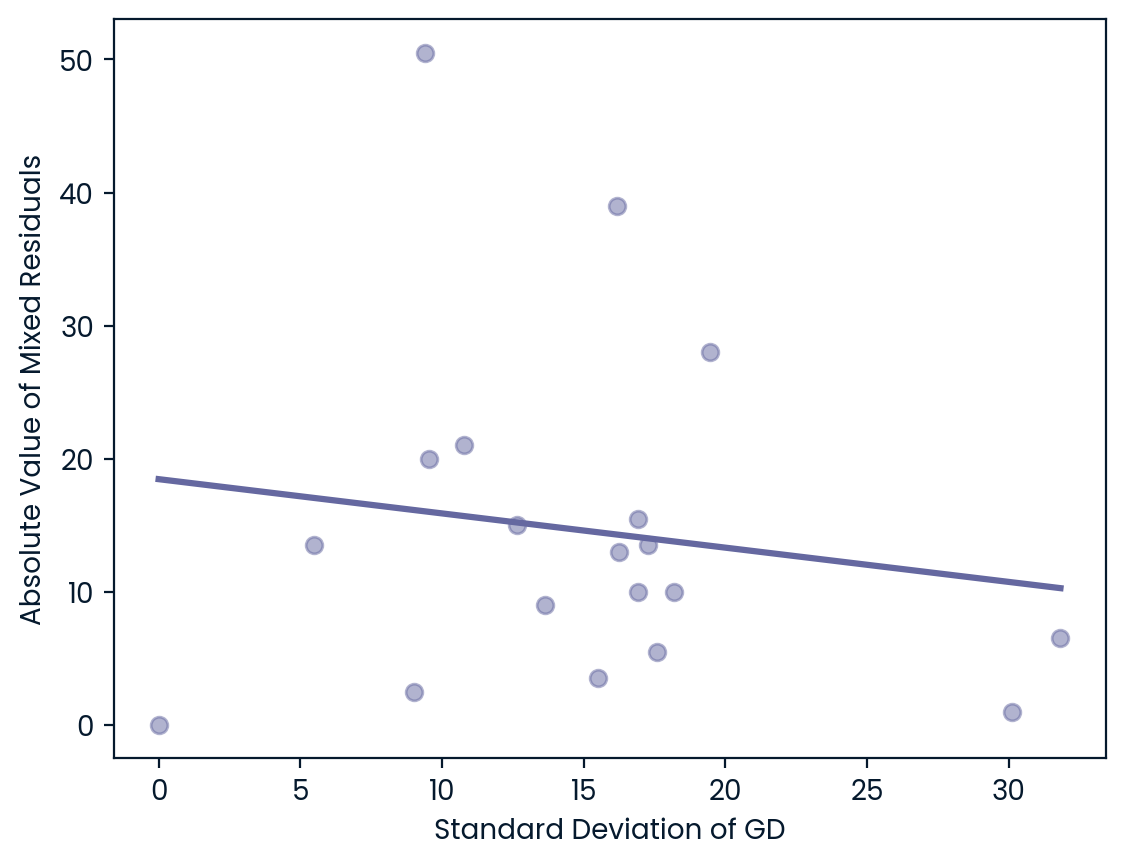

In [235]:
abs_resids = [abs(x) for x in residuals]
abs_resids

sns.regplot(x=teams_gd_predictions_df["GD_Std_Dev"], y=abs_resids, ci=None, scatter_kws={'alpha':0.5})
plt.title("")
plt.xlabel("Standard Deviation of GD")
plt.ylabel("Absolute Value of Mixed Residuals")
plt.show()

This shows that there really isnt any correlation between the two values. Lets create a multiple linear regression model that uses NAMV and Year to predict GD.

In [236]:
model_data = data.drop(columns=["Position", "Points", "Average_Market_Value"])
model_data = model_data.head(len(model_data)-20)
model_data

,Team,Goal_Difference,Year,Normalized_Average_Market_Value
0,chelsea fc,57,2004,1.000000
1,manchester united,32,2004,0.741815
2,arsenal fc,51,2004,0.624883
3,liverpool fc,11,2004,0.547240
4,tottenham hotspur,6,2004,0.321796
...,...,...,...,...
355,brentford fc,-8,2021,0.279332
356,crystal palace,4,2021,0.318959
357,norwich city,-61,2021,0.141026
358,watford fc,-43,2021,0.128982


In [237]:
predictions = []
for i in range(20):
    team = teams2223[i]
    team_df = model_data[model_data['Team'] == team]
    team_std_dev = team_df["Goal_Difference"].std()
    
    team_degree = 2 if(team_std_dev > 18) else 1
    if not team_df.empty: 
        # Selecting the features and target variable
        features = ['Year', 'Normalized_Average_Market_Value']
        X = team_df[features]
        y = team_df['Goal_Difference']
        
        # Transforming the features into polynomial features of degree 2
        poly = PolynomialFeatures(degree=team_degree)
        X_poly = poly.fit_transform(X)
        
        # Creating the model
        poly_lin_reg_model = LinearRegression()

        # Fitting the model with polynomial features
        poly_lin_reg_model.fit(X_poly, y)
        
        # Predicting
        namv = gd_data_2223["Normalized_Average_Market_Value"].tolist()[i]
        new_data_year = pd.DataFrame({'Year': [2022], 'Normalized_Average_Market_Value': [namv]})
        new_data_year_poly = poly.transform(new_data_year)
        predictions.append(poly_lin_reg_model.predict(new_data_year_poly)[0].round())
    else:
        predictions.append(-30)

In [238]:
teams_gd_predictions_df

,Team,Real_GD,Namv_GD,Year_GD,GD_Std_Dev,Namv_GD_Residual,Year_GD_Residual,Mixed_Residual,Is_Combining_Better
360,manchester city,61,60.0,60.0,30.100920,1.0,1.0,1.0,False
361,arsenal fc,45,34.0,14.0,10.780186,11.0,31.0,21.0,False
362,chelsea fc,-9,24.0,36.0,16.172780,-33.0,-45.0,-39.0,False
363,manchester united,15,29.0,21.0,16.905446,-14.0,-6.0,-10.0,True
364,liverpool fc,28,36.0,76.0,19.439617,-8.0,-48.0,-28.0,False
365,tottenham hotspur,7,5.0,16.0,15.518069,2.0,-9.0,-3.5,False
366,newcastle united,35,-13.0,-18.0,9.409215,48.0,53.0,50.5,False
367,brighton & hove albion,19,-5.0,3.0,9.555103,24.0,16.0,20.0,True
368,aston villa,5,-9.0,39.0,18.180838,14.0,-34.0,-10.0,True
369,wolverhampton wanderers,-27,-17.0,-26.0,17.577041,-10.0,-1.0,-5.5,True


In [239]:
gd_data_2223["Predictions"] = predictions
gd_data_2223

,Team,Goal_Difference,Normalized_Average_Market_Value,Predictions
360,manchester city,61,1.000000,87.0
361,arsenal fc,45,0.707122,17.0
362,chelsea fc,-9,0.686647,22.0
363,manchester united,15,0.524332,12.0
364,liverpool fc,28,0.617804,81.0
365,tottenham hotspur,7,0.566469,20.0
366,newcastle united,35,0.422849,-23.0
367,brighton & hove albion,19,0.374184,4.0
368,aston villa,5,0.351632,7.0
369,wolverhampton wanderers,-27,0.343323,7.0


In [240]:
diff = 0
for i in range(20):
    actual = gd_data_2223["Goal_Difference"].iloc[i]
    prediction = gd_data_2223["Predictions"].iloc[i]
    diff += abs(prediction - actual)
diff /= 20
diff

22.8

Conclusion:  
This is resulting in a worse result than either of the Singlular Regression models that take in NAMV/Year to predict GD. I presume that this is because each of those models produce best results when their degrees are set to different values at different standard deviations. My current solution to this dillemma is to use two different singlular regression models instead of using one multiple regression model. A final trend I would like to assess is that the Mixed_Residual has been created by taking the average of the Namv_Prediction and the Year_Prediction. I want to explore the idea of creating a weighted average of various percentages to see if that increases the prediction aaccuracy.

# Models:
  
**1) def gd_namv_prediction_model(num_degrees, std_dev, plots):**  
ideal when the model is created with **_degrees: 2_** for teams with a **_std_dev: 18_** or more.   
populates gd_namv_predictions  
  
**2) def gd_year_prediction_model(num_degrees, std_dev, plots):**
ideal when the model is created with **_degrees: 3_** for teams with a **_std_dev: 12_** or more.   
populates gd_year_predictions

In [291]:
#Create GD Predictions and populate arrays with them
gd_year_prediction_model(3, 12, False)
gd_namv_prediction_model(2, 18, False)

real_gd = teams_gd_predictions_df["Real_GD"].tolist()
weights = [0.30, 0.40, 0.50, 0.55, 0.60, 0.65, 0.70, 0.80, 0.90] #Weight of NAMV
weight_results = pd.DataFrame() #2d array 
weight_accuracy = [] #1d array of accuracies
#test various weights
for i in weights:
    weight_result = []
    error = 0
    for j in range(20):
        value = round(i * gd_namv_predictions[j] + (1 - i) * gd_year_predictions[j], 2)
        error += abs(real_gd[j] - value)
        weight_result.append(value)
    weight_results[str(i)] = weight_result
    error /= 20
    weight_accuracy.append(error)

In [292]:
weight_results.loc[20] = weight_accuracy
weight_results

,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.8,0.9
0,60.00,60.00,60.00,60.000,60.00,60.00,60.00,60.00,60.00
1,20.00,22.00,24.00,25.000,26.00,27.00,28.00,30.00,32.00
2,32.40,31.20,30.00,29.400,28.80,28.20,27.60,26.40,25.20
3,23.40,24.20,25.00,25.400,25.80,26.20,26.60,27.40,28.20
4,64.00,60.00,56.00,54.000,52.00,50.00,48.00,44.00,40.00
5,12.70,11.60,10.50,9.950,9.40,8.85,8.30,7.20,6.10
6,-16.50,-16.00,-15.50,-15.250,-15.00,-14.75,-14.50,-14.00,-13.50
7,0.60,-0.20,-1.00,-1.400,-1.80,-2.20,-2.60,-3.40,-4.20
8,24.60,19.80,15.00,12.600,10.20,7.80,5.40,0.60,-4.20
9,-23.30,-22.40,-21.50,-21.050,-20.60,-20.15,-19.70,-18.80,-17.90


Conclusion:  
Based on these results, it can be seen that the creation of a model that predicts GD while using Year and NAMV as inputs works best when the output is a weighted average that consists of 60% NAMV and 40% Year.  
  
In other words, we have two Single Regression models which take in NAMV/Year as input and output the GD for each team. We create a number which is the weighted average of the NAMV output (60%) and the Year output (40%). This number is the GD prediction for a particular team for the next 